In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import DBSCAN
import math
import statistics
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
import json


#Convert CSV to Dataframe"C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\data\pairwise_user_experiment.csv"
data = pd.read_csv("./data/pairwise_user_experiment.csv", header=[0])
data["FOLDER"] = data["IN FILE"].apply(lambda x: "")
data["LAST MOD BY"] = data["LAST MOD BY"].apply(lambda x: x.split(" ")[0])
data

IN FILE  CLIP LENGTH   OFFSET  \
0     XC23899_-_White-vented_Shama_-_Copsychus_niger...      61.1034   1.1839   
1     XC23899_-_White-vented_Shama_-_Copsychus_niger...      61.1034   6.9715   
2     XC23899_-_White-vented_Shama_-_Copsychus_niger...      61.1034   8.8594   
3     XC23899_-_White-vented_Shama_-_Copsychus_niger...      61.1034   9.9393   
4     XC23899_-_White-vented_Shama_-_Copsychus_niger...      61.1034  15.1890   
...                                                 ...          ...      ...   
2243  XC688950_-_Balearic_Warbler_-_Sylvia_balearica...      25.9531  22.3916   
2244  XC688950_-_Balearic_Warbler_-_Sylvia_balearica...      25.9531  23.7316   
2245  XC688950_-_Balearic_Warbler_-_Sylvia_balearica...      25.9531  24.2615   
2246  XC688950_-_Balearic_Warbler_-_Sylvia_balearica...      25.9531  24.7815   
2247  XC688950_-_Balearic_Warbler_-_Sylvia_balearica...      25.9531  25.3315   

      DURATION  MAX FREQ  MIN FREQ  SAMPLE RATE           MANUAL ID  \
0       1.3399     24000         0        48000  White-vented Shama   
1       1.5479     24000         0        48000  White-vented Shama   
2       0.4500     24000         0        48000  White-vented Shama   
3       1.0800     24000         0        48000  White-vented Shama   
4       0.9299     24000         0        48000  White-vented Shama   
...        ...       ...       ...          ...                 ...   
2243    0.8100     24000         0        48000                bird   
2244    0.1600     24000         0        48000                bird   
2245    0.1200     24000         0        48000                bird   
2246    0.1600     24000         0        48000                bird   
2247    0.1400     24000         0        48000                bird   

      TIME_SPENT LAST MOD BY  CONFIDENCE  RETIRED  COUNTED FOLDER  
0        141.864       spres    0.577908    False        0         
1        141.864       spres    0.577908    False        0         
2        141.864       spres    0.577908    False        0         
3        141.864       spres    0.577908    False        0         
4        141.864       spres    0.577908    False        0         
...          ...         ...         ...      ...      ...    ...  
2243     311.194      Anshul    0.300511    False        0         
2244     311.194      Anshul    0.300511    False        0         
2245     311.194      Anshul    0.300511    False        0         
2246     311.194      Anshul    0.300511    False        0         
2247     311.194      Anshul    0.300511    False        0         

[2248 rows x 14 columns]

#### Import Confidence Functions and Create List of Functions

In [3]:

 
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
confidence_funcs

[<function confidence_functions.confidence.get_silhoutte_confidence(df, users)>,
 <function confidence_functions.confidence.get_silhoutte_users_confidence(df, users)>,
 <function confidence_functions.confidence.fast_majority_vote(df, users, chunk_length=3)>,
 <function confidence_functions.confidence.get_pairwise_iou(df, users)>]

### permuatation code

In [4]:
def permutate_users(df, num_users, clip_name, confidence_func):
    #Get data for indivual clip
    results = []
    df = df[df["IN FILE"] == clip_name]
    users = df["LAST MOD BY"].unique()
    
    for user_permutation in itertools.permutations(users, num_users):
        try:
            results.append(confidence_func(df, user_permutation))
        except:
            pass
        
    results = np.mean(results)
    return results
    
#permutate_users(data, 2, "XC425555_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", get_silhoutte_users_confidence)

### Clip Spefific Experiment

In [5]:
def determine_confidence_by_clip(df, clip_name, confidence_funcs):
    results = {}
    df = df[df["IN FILE"] == clip_name]
    users = df["LAST MOD BY"].unique()
    for confidence_func in confidence_funcs:
        print("working with function: " + confidence_func.__name__)
        results[confidence_func] = {}
        
        for user_count in range(6):
            results[confidence_func][user_count+1]= permutate_users(df, user_count+1, clip_name, confidence_func)
    return results

def determine_confidence_by_func(df, confidence_funcs):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func] = {}
        for user_count in range(6):
            print("USER", user_count)
            confidence = np.array([])
            for file in files:
                if (user_count < len(df[df["IN FILE"] == file]["LAST MOD BY"].unique())):
                       confidence = np.append(confidence, permutate_users(df, user_count+1, file, func))
            print(confidence)
            confidence = confidence.mean()
            results[func][user_count+1] = confidence
    return results
        
#determine_confidence_by_clip(data, "XC425555_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", confidence_funcs)
#determine_confidence_by_func(data, confidence_funcs)

# Full Experiment

In [6]:
def run_experiment(df, confidence_funcs):
    #Get the adverage confidence over number of users for each file
    results = {"by_clip": {}, "Over_all_clips": {}}
    filenames = df["IN FILE"].unique()
    #for file in filenames:
    #    print("working with file: " + file)
    #    results["by_clip"][file] = determine_confidence_by_clip(df, file, confidence_funcs)
    
    print("Get adverage over all files")
    results["Over_all_clips"] = determine_confidence_by_func(df, confidence_funcs)
        
        
    
    return results

#experiment_results = run_experiment(data, confidence_funcs)
#experiment_results

In [7]:
def generate_graph(experiment_results):
    for filename in experiment_results:
        #For each filename, plot the performance of each confidence function
        for confidence_func in experiment_results[filename]:
            confidence_dirc = experiment_results[filename][confidence_func]
            users_count = list(confidence_dirc.keys())
            score = list(confidence_dirc.values())
            plt.plot(users_count, score, label=(confidence_func.__name__))
        
        #Throw in some fancy formatting
        plt.legend(loc='best')
        plt.title(filename)
        plt.xlabel("User Count")
        plt.ylabel("Average Confidence of Function")
        plt.show()

#generate_graph(experiment_results["by_clip"])

In [8]:
def generate_graph_all(experiment_results):
    #For each filename, plot the performance of each confidence function
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        users_count = list(confidence_dirc.keys())
        score = list(confidence_dirc.values())
        plt.plot(users_count, score, label=(confidence_func.__name__))

    #Throw in some fancy formatting
    plt.legend(loc='best')
    #plt.title(filename)
    plt.xlabel("User Count")
    plt.ylabel("Average Confidence of Function")
    plt.show()
    
    
    
    
#generate_graph_all(experiment_results["Over_all_clips"])
#Experiment Failed -> To Time Complex

## Experiment Design 2

In [9]:
def experiment_via_random_orders(df, confidence_funcs, num_of_orders=1000):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func.__name__] = {}
        for i in range (len(users)):
            results[func.__name__][i] = []
    
    
    for file in files:
        print("on ", file, "of", len(files))
        tmp_df = df[df["IN FILE"] == file]
        users = tmp_df["LAST MOD BY"].unique()

        to_be_randomly_inserted = np.tile(users, (num_of_orders, 1))
        to_be_randomly_inserted = pd.DataFrame(to_be_randomly_inserted)
        to_be_randomly_inserted = to_be_randomly_inserted.apply(lambda x:np.random.shuffle(x) or x, axis=1)
        random_insertion_orders = to_be_randomly_inserted.values
        
        count = 0
        for insertion_order in random_insertion_orders:
            print(count)
            count += 1
            for func in confidence_funcs: 
                for user_count in range(1,len(insertion_order)):
                    curr_insert = insertion_order[:user_count+1]
                    tmp_df_users = tmp_df[tmp_df["LAST MOD BY"].isin(curr_insert)]
                    try:
                        results[func.__name__][user_count].append(func(tmp_df_users, curr_insert))
                    except:
                        pass
        json_object = json.dumps(results, indent=4)
 
        # Writing to sample.json
        with open("experiment_results.json", "w") as outfile:
            outfile.write(json_object)
    return results

#experiment_results = experiment_via_random_orders(data, confidence_funcs, 1000)
#experiment_results
#Experiment Failed -> To Time Complex

# Experiment 3, Work to Save Time

In [7]:
import time

 
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
confidence_funcs

def experiment_3(df, confidence_funcs, num_of_trials=10):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func.__name__] = {}
        for i in range (len(users)):
            results[func.__name__][i] = []
        results[func.__name__]["TIMING"] = []
    
    
    for trial in range(num_of_trials):
        start = time.time()
        print("============================")
        print(trial)
        file  = np.random.choice(files, size=None, replace=True, p=None)
        tmp_df = df[df["IN FILE"] == file]
        users = tmp_df["LAST MOD BY"].unique()

        to_be_randomly_inserted = np.tile(users, (1, 1))
        to_be_randomly_inserted = pd.DataFrame(to_be_randomly_inserted)
        to_be_randomly_inserted = to_be_randomly_inserted.apply(lambda x:np.random.shuffle(x) or x, axis=1)
        random_insertion_orders = to_be_randomly_inserted.values
        
        end = time.time()
        #print("Set Up", end - start)
        
        for insertion_order in random_insertion_orders:
            for func in confidence_funcs:
                start = time.time()
                for user_count in range(1,len(insertion_order)):
                    curr_insert = insertion_order[:user_count+1]
                    tmp_df_users = tmp_df[tmp_df["LAST MOD BY"].isin(curr_insert)]
                    try:
                        results[func.__name__][user_count].append(func(tmp_df_users, curr_insert))
                    except:
                        pass
                end = time.time()
                print(func.__name__, end - start)
                results[func.__name__]["TIMING"].append(end - start)
                    
        results["TRIAL COUNT"] = trial
        json_object = json.dumps(results, indent=4)
 
        # Writing to sample.json
        with open("experiment_results.json", "w") as outfile:
            outfile.write(json_object)
        
    return results

In [11]:
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000)

0


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21150422096252441


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2126142978668213
fast_majority_vote 0.5038998126983643
get_pairwise_iou 0.6558220386505127
1


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21499013900756836
get_silhoutte_users_confidence 0.21789193153381348


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.2298059463500977
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.6160073280334473
2


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4619874954223633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4643988609313965
fast_majority_vote 3.4837350845336914
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.002602577209473
3
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17894601821899414
get_silhoutte_users_confidence 0.18359827995300293


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4743795394897461
get_pairwise_iou 1.1442623138427734
4
get_silhoutte_confidence 0.14858436584472656


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14894318580627441
fast_majority_vote 0.5121462345123291
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7709136009216309
5


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.25115537643432617


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.27236270904541016
fast_majority_vote 1.1937196254730225
get_pairwise_iou 2.2476072311401367
6
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.200272798538208
get_silhoutte_users_confidence 0.20824289321899414


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5073103904724121
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.1620373725891113
7


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23627543449401855


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23928213119506836
fast_majority_vote 0.5543348789215088
get_pairwise_iou 0.6406064033508301
8
get_silhoutte_confidence 0.16456985473632812


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16781330108642578
fast_majority_vote 0.19362235069274902
get_pairwise_iou 0.596980094909668
9


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21410298347473145


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21996331214904785
fast_majority_vote 0.7133476734161377
get_pairwise_iou 1.3618628978729248
10


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.34767937660217285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3485109806060791
fast_majority_vote 1.4375715255737305
get_pairwise_iou 3.9570107460021973
11
get_silhoutte_confidence 0.14693737030029297


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14911723136901855
fast_majority_vote 0.6549344062805176
get_pairwise_iou 1.5615143775939941
12


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.3024289608001709


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2975151538848877
fast_majority_vote 1.316704273223877
get_pairwise_iou 2.5418078899383545
13
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.185197114944458
get_silhoutte_users_confidence 0.18287324905395508


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.33202552795410156
get_pairwise_iou 0.639014482498169
14
get_silhoutte_confidence 0.16258978843688965


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16408324241638184
fast_majority_vote 0.731541633605957
get_pairwise_iou 1.373051643371582
15


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23786330223083496


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23510432243347168
fast_majority_vote 0.68650221824646
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.417032241821289
16


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3602869510650635


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36205267906188965
fast_majority_vote 1.245067834854126
get_pairwise_iou 2.565884828567505
17
get_silhoutte_confidence 0.16601967811584473


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.1750180721282959
fast_majority_vote 0.39496660232543945
get_pairwise_iou 0.839653491973877
18


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.496931791305542
get_silhoutte_users_confidence 0.5099697113037109
fast_majority_vote 3.315117835998535
get_pairwise_iou 9.531128644943237
19
get_silhoutte_confidence 0.12382030487060547


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.12582731246948242
fast_majority_vote 0.36344122886657715
get_pairwise_iou 0.47075772285461426
20


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4462580680847168


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4425685405731201
fast_majority_vote 3.2870445251464844
get_pairwise_iou 7.105065584182739
21
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17850565910339355
get_silhoutte_users_confidence 0.1829235553741455


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 1.2058451175689697
get_pairwise_iou 2.3740618228912354
22
get_silhoutte_confidence 0.17197942733764648


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1771078109741211
fast_majority_vote 0.40489697456359863
get_pairwise_iou 0.6602301597595215
23


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32167649269104004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3175997734069824
fast_majority_vote 1.43192458152771
get_pairwise_iou 2.2479114532470703
24


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27463603019714355


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2744293212890625
fast_majority_vote 0.642918586730957
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0379447937011719
25
get_silhoutte_confidence 0.12756919860839844


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13063454627990723
fast_majority_vote 0.6043815612792969
get_pairwise_iou 1.3222277164459229
26


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3609778881072998


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3572821617126465
fast_majority_vote 1.4254460334777832
get_pairwise_iou 4.133133172988892
27


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18924546241760254
get_silhoutte_users_confidence 0.1938495635986328


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2127699851989746
get_pairwise_iou 0.6033313274383545
28


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.21743035316467285
get_silhoutte_users_confidence 0.218644380569458
fast_majority_vote 0.4876089096069336
get_pairwise_iou 1.254990577697754
29


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34754014015197754


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.34954047203063965
fast_majority_vote 1.5330173969268799
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.191094875335693
30


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24564862251281738


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24566888809204102
fast_majority_vote 0.6028568744659424
get_pairwise_iou 0.8539941310882568
31


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23094797134399414


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23505258560180664
fast_majority_vote 0.5283935070037842
get_pairwise_iou 0.5761325359344482
32


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3349423408508301


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.336871862411499
fast_majority_vote 1.4848215579986572
get_pairwise_iou 2.339097023010254
33


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19662117958068848
get_silhoutte_users_confidence 0.20660662651062012


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.22091460227966309
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5809955596923828
34


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2547428607940674


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2611997127532959
fast_majority_vote 0.3600900173187256
get_pairwise_iou 0.6799709796905518
35


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2397596836090088
get_silhoutte_users_confidence 0.2360668182373047
fast_majority_vote 1.3218958377838135
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero d

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2509760856628418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2448868751525879
fast_majority_vote 0.5740315914154053
get_pairwise_iou 0.948859453201294
37


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.20898199081420898
get_silhoutte_users_confidence 0.21036791801452637
fast_majority_vote 0.46786975860595703
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zer

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3122522830963135


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.31082582473754883
fast_majority_vote 1.0977423191070557
get_pairwise_iou 2.6312546730041504
39


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.243133544921875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23881077766418457
fast_majority_vote 0.2471933364868164
get_pairwise_iou 0.7778236865997314
40


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.45264744758605957


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.44197869300842285
fast_majority_vote 3.4640135765075684
get_pairwise_iou 6.966697931289673
41
get_silhoutte_confidence 0.16285943984985352


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.17125892639160156
fast_majority_vote 0.5266754627227783
get_pairwise_iou 1.3139169216156006
42


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24110031127929688


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2408599853515625
fast_majority_vote 0.33200979232788086
get_pairwise_iou 0.6610550880432129
43


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24664759635925293


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24056267738342285
fast_majority_vote 0.3804330825805664
get_pairwise_iou 0.6467912197113037
44


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19836878776550293
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20543384552001953
fast_majority_vote 0.6361057758331299
get_pairwise_iou 1.534639835357666
45
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17877674102783203
get_silhoutte_users_confidence 0.18687915802001953


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.22142457962036133
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6061561107635498
46
get_silhoutte_confidence 0.1559128761291504


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16092729568481445
fast_majority_vote 0.6849710941314697
get_pairwise_iou 1.3621435165405273
47
get_silhoutte_confidence 0.14536356925964355


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.14922046661376953
fast_majority_vote 1.1092474460601807
get_pairwise_iou 2.5781290531158447
48


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34000539779663086


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3469686508178711
fast_majority_vote 1.5520408153533936
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.023622035980225
49


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.36317920684814453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36382365226745605
fast_majority_vote 1.3240883350372314
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.7022147178649902
50


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.25247764587402344


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23636865615844727
fast_majority_vote 0.4911041259765625
get_pairwise_iou 1.386155366897583
51
get_silhoutte_confidence 0.1603403091430664


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.170090913772583
fast_majority_vote 0.40501952171325684
get_pairwise_iou 1.1393742561340332
52


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.264117956161499


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2683377265930176
fast_majority_vote 0.3535277843475342
get_pairwise_iou 0.7250940799713135
53


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23080730438232422


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2332913875579834
fast_majority_vote 0.5188872814178467
get_pairwise_iou 0.6850929260253906
54


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21235108375549316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21861052513122559
fast_majority_vote 0.5003859996795654
get_pairwise_iou 0.6805551052093506
55


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3878493309020996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3888120651245117
fast_majority_vote 1.4978079795837402
get_pairwise_iou 2.877117156982422
56
get_silhoutte_confidence 0.16285395622253418


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.16453337669372559
fast_majority_vote 0.4939601421356201
get_pairwise_iou 1.530177354812622
57
get_silhoutte_confidence 0.13664841651916504


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13794255256652832
fast_majority_vote 0.6314041614532471
get_pairwise_iou 1.3284399509429932
58


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.46552133560180664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4644906520843506
fast_majority_vote 1.2009906768798828
get_pairwise_iou 2.1750946044921875
59


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20391154289245605
get_silhoutte_users_confidence 0.20278358459472656


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.9600505828857422
get_pairwise_iou 2.1255879402160645
60


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2950272560119629


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.29691386222839355
fast_majority_vote 0.6570758819580078
get_pairwise_iou 1.0201716423034668
61


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5128917694091797


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.5300238132476807
fast_majority_vote 1.1320247650146484
get_pairwise_iou 2.1462008953094482
62
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1864168643951416
get_silhoutte_users_confidence 0.1910264492034912


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.21900653839111328
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5709402561187744
63
get_silhoutte_confidence 0.16794419288635254


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1729896068572998
fast_majority_vote 0.3350193500518799
get_pairwise_iou 0.7190456390380859
64


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30004262924194336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.29706811904907227
fast_majority_vote 0.39589381217956543
get_pairwise_iou 0.6662929058074951
65
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17336201667785645
get_silhoutte_users_confidence 0.19292140007019043


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.33989739418029785
get_pairwise_iou 0.7670652866363525
66


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22606563568115234


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22700715065002441
fast_majority_vote 0.6627793312072754
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3909311294555664
67


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.43804144859313965


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.43299102783203125
fast_majority_vote 3.2292134761810303
get_pairwise_iou 6.640232801437378
68


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35396242141723633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.35506105422973633
fast_majority_vote 1.4821264743804932
get_pairwise_iou 2.962944269180298
69


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.31697583198547363


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3124535083770752
fast_majority_vote 1.1075615882873535
get_pairwise_iou 2.67557430267334
70


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5580050945281982


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4727203845977783
fast_majority_vote 3.30172061920166
get_pairwise_iou 7.1739771366119385
71


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19592809677124023
get_silhoutte_users_confidence 0.19841575622558594


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 1.0842299461364746
get_pairwise_iou 1.1394426822662354
72
get_silhoutte_confidence 0.16484618186950684


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.16589808464050293
fast_majority_vote 1.1978840827941895
get_pairwise_iou 2.471623182296753
73


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19829082489013672
get_silhoutte_users_confidence 0.1958448886871338


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 1.0839617252349854
get_pairwise_iou 1.4952924251556396
74


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24147415161132812


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24250459671020508
fast_majority_vote 0.5489046573638916
get_pairwise_iou 0.6111433506011963
75


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4669764041900635


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.47417306900024414
fast_majority_vote 3.0457890033721924
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.174561262130737
76


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24631571769714355
get_silhoutte_users_confidence 0.24436330795288086
fast_majority_vote 0.5007953643798828
get_pairwise_iou 1.6903669834136963
77
get_silhoutte_confidence 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0.17412662506103516
get_silhoutte_users_confidence 0.1696772575378418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2690756320953369
get_pairwise_iou 0.706437349319458
78


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22713685035705566


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22750186920166016
fast_majority_vote 1.2995710372924805
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcu

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.18264222145080566
get_silhoutte_users_confidence 0.1866450309753418
fast_majority_vote 0.33686113357543945
get_pairwise_iou 0.7824265956878662
80
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.18813705444335938
get_silhoutte_users_confidence 0.19500422477722168


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.34508347511291504
get_pairwise_iou 0.6785295009613037
81


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21252083778381348


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21293282508850098
fast_majority_vote 1.0284218788146973
get_pairwise_iou 1.6578326225280762
82


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2251427173614502
get_silhoutte_users_confidence 0.22505807876586914
fast_majority_vote 0.4996914863586426
get_pairwise_iou 1.3689210414886475
83
get_silhoutte_confidence 0.15761852264404297


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16293787956237793
fast_majority_vote 0.5011515617370605
get_pairwise_iou 1.2614362239837646
84


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30144429206848145


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3023650646209717
fast_majority_vote 0.39733147621154785
get_pairwise_iou 0.6986310482025146
85


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23135685920715332


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23620867729187012
fast_majority_vote 0.46842479705810547
get_pairwise_iou 0.6875073909759521
86


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.28780603408813477


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.285799503326416
fast_majority_vote 0.35151100158691406
get_pairwise_iou 0.747427225112915
87


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.391465425491333


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3945765495300293
fast_majority_vote 1.224066972732544
get_pairwise_iou 2.246065139770508
88


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2333674430847168
get_silhoutte_users_confidence 0.241302490234375
fast_majority_vote 1.3565623760223389
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero di

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.14257550239562988
get_silhoutte_users_confidence 0.14078307151794434


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.35746169090270996
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5555167198181152
90
get_silhoutte_confidence 0.17594480514526367


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.18063950538635254
fast_majority_vote 0.5262401103973389
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4800968170166016
91


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21346282958984375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2146923542022705
fast_majority_vote 0.6359052658081055
get_pairwise_iou 1.32863187789917
92


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1913294792175293
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19534850120544434
fast_majority_vote 0.23030757904052734
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6658387184143066
93
g

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.19525361061096191
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1992192268371582
fast_majority_vote 0.8020734786987305
get_pairwise_iou 2.1476333141326904
94


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20850872993469238
get_silhoutte_users_confidence 0.20555520057678223


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 1.0337626934051514
get_pairwise_iou 1.9928956031799316
95
get_silhoutte_confidence 0.14850425720214844


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.1522219181060791
fast_majority_vote 0.35051894187927246
get_pairwise_iou 0.7278361320495605
96
get_silhoutte_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17087030410766602
get_silhoutte_users_confidence 0.17356228828430176


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.34136486053466797
get_pairwise_iou 0.7921192646026611
97


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2893211841583252


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.29082465171813965
fast_majority_vote 0.6725983619689941
get_pairwise_iou 1.3562376499176025
98


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2347414493560791


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22900795936584473
fast_majority_vote 0.3336622714996338
get_pairwise_iou 0.8100728988647461
99


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4451634883880615


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.44803547859191895
fast_majority_vote 3.445493698120117
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.555715322494507
100


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2104649543762207


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21274542808532715
fast_majority_vote 0.2706782817840576
get_pairwise_iou 0.751356840133667
101
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19144105911254883
get_silhoutte_users_confidence 0.20903253555297852


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.37473464012145996
get_pairwise_iou 0.7763106822967529
102


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2008819580078125
get_silhoutte_users_confidence 0.19613289833068848


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.9973108768463135
get_pairwise_iou 1.456482172012329
103
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17349457740783691
get_silhoutte_users_confidence 0.17412543296813965


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.47905445098876953
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0446045398712158
104


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2780883312225342


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.27460598945617676
fast_majority_vote 0.36325955390930176
get_pairwise_iou 0.7052047252655029
105


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21944093704223633
get_silhoutte_users_confidence 0.22483420372009277
fast_majority_vote 0.5018868446350098
get_pairwise_iou 0.6578729152679443
106


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.21778488159179688
get_silhoutte_users_confidence 0.22243165969848633
fast_majority_vote 0.49764180183410645
get_pairwise_iou 1.301978588104248
107


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35463380813598633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3535442352294922
fast_majority_vote 1.237358570098877
get_pairwise_iou 2.570504665374756
108
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.19777393341064453
get_silhoutte_users_confidence 0.19957876205444336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6627600193023682
get_pairwise_iou 1.3055028915405273
109
get_silhoutte_confidence 0.1468501091003418


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14564752578735352
fast_majority_vote 0.6609694957733154
get_pairwise_iou 1.44163179397583
110
get_silhoutte_confidence 0.13773059844970703


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13991427421569824
fast_majority_vote 0.34793639183044434
get_pairwise_iou 0.5912210941314697
111


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.42813873291015625


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4362480640411377
fast_majority_vote 3.469430923461914
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 7.563404560089111
112
get_silhoutte_confidence 0.1304483413696289


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13576602935791016
fast_majority_vote 0.38993191719055176
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.725780725479126
113
get_silhoutte_confidence 0.1394517421722412


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14560699462890625
fast_majority_vote 0.36104679107666016
get_pairwise_iou 0.5998423099517822
114


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23073482513427734
get_silhoutte_users_confidence 0.22954249382019043
fast_majority_vote 1.329615831375122
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4139368534088135


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.40017199516296387
fast_majority_vote 1.5648632049560547
get_pairwise_iou 2.523960590362549
116


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.25043630599975586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24573016166687012
fast_majority_vote 0.5021963119506836
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5381999015808105
117


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21149873733520508


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2178487777709961
fast_majority_vote 0.4613621234893799
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.258763313293457
118


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.451418399810791
get_silhoutte_users_confidence 0.4681668281555176
fast_majority_vote 3.7585904598236084
get_pairwise_iou 9.970115423202515
119


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.37137269973754883


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.34868955612182617
fast_majority_vote 1.1514227390289307
get_pairwise_iou 2.6626293659210205
120
get_silhoutte_confidence 0.14101886749267578


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14074397087097168
fast_majority_vote 0.41875433921813965
get_pairwise_iou 0.67195725440979
121


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20273995399475098
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20871424674987793
fast_majority_vote 0.22646474838256836
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6073684692382812
122


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.38194704055786133
get_silhoutte_users_confidence 0.37881994247436523
fast_majority_vote 1.7910287380218506
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.075200080871582
123


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.49608778953552246


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.42444300651550293
fast_majority_vote 2.142641544342041
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.414950132369995
124
get_silhoutte_confidence 0.15820693969726562


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.15653753280639648
fast_majority_vote 0.4878520965576172
get_pairwise_iou 0.7690825462341309
125
get_silhoutte_confidence 0.14093327522277832


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1424107551574707
fast_majority_vote 0.3679189682006836
get_pairwise_iou 0.43006181716918945
126


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30646371841430664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.312122106552124
fast_majority_vote 1.0713987350463867
get_pairwise_iou 2.2977731227874756
127
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17525672912597656
get_silhoutte_users_confidence 0.17821669578552246


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.533928394317627
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4322218894958496
128


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.24605703353881836


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24837756156921387
fast_majority_vote 0.5051286220550537
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.700040340423584
129


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3240029811859131


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3255443572998047
fast_majority_vote 1.134958267211914
get_pairwise_iou 2.448608160018921
130


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18860077857971191
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1936204433441162
fast_majority_vote 0.6283602714538574
get_pairwise_iou 1.439758539199829
131
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.16807961463928223
get_silhoutte_users_confidence 0.17366290092468262


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.747976541519165
get_pairwise_iou 1.392493724822998
132
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19407320022583008
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19541478157043457
fast_majority_vote 1.0072524547576904
get_pairwise_iou 1.512082576751709
133


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2126457691192627
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.21631073951721191
fast_majority_vote 1.2658498287200928
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.4009592533111572
134
get_silhoutte_confidence 0.16094088554382324


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16446828842163086
fast_majority_vote 0.26326465606689453
get_pairwise_iou 0.7133924961090088
135


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2469651699066162


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2474350929260254
fast_majority_vote 0.49501514434814453
get_pairwise_iou 1.604461431503296
136


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20055556297302246
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20208001136779785
fast_majority_vote 0.6763718128204346
get_pairwise_iou 1.4551258087158203
137


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2699418067932129


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23632192611694336
fast_majority_vote 0.3099837303161621
get_pairwise_iou 0.7597908973693848
138


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.20224380493164062
get_silhoutte_users_confidence 0.20508146286010742
fast_majority_vote 0.3760344982147217
get_pairwise_iou 0.8016483783721924
139


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24344801902770996
get_silhoutte_users_confidence 0.24587249755859375
fast_majority_vote 0.4865376949310303
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4346203804016113
140
get_silhoutte_confidence 0.16515707969665527


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.1674661636352539
fast_majority_vote 0.9024660587310791
get_pairwise_iou 2.2220091819763184
141
get_silhoutte_confidence 0.14571571350097656


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14481329917907715
fast_majority_vote 0.43507957458496094
get_pairwise_iou 0.6410329341888428
142


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19087696075439453
get_silhoutte_users_confidence 0.19309043884277344


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6228840351104736
get_pairwise_iou 1.4856047630310059
143


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2580904960632324


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24808192253112793
fast_majority_vote 0.45070528984069824
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5766754150390625
144


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23305654525756836


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23075222969055176
fast_majority_vote 0.5024912357330322
get_pairwise_iou 0.6889526844024658
145
get_silhoutte_confidence 0.13596367835998535


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1412808895111084
fast_majority_vote 0.26051759719848633
get_pairwise_iou 0.6883904933929443
146


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3276371955871582


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3276221752166748
fast_majority_vote 1.1453633308410645
get_pairwise_iou 2.502492904663086
147
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1780695915222168
get_silhoutte_users_confidence 0.17993402481079102


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.49387264251708984
get_pairwise_iou 1.171081304550171
148


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24570035934448242


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24427580833435059
fast_majority_vote 0.3949589729309082
get_pairwise_iou 0.7226982116699219
149
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17124152183532715
get_silhoutte_users_confidence 0.17981433868408203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.388730525970459
get_pairwise_iou 0.8653287887573242
150


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23748564720153809


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2165524959564209
fast_majority_vote 1.1901066303253174
get_pairwise_iou 1.6237514019012451
151


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.345858097076416


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2955796718597412
fast_majority_vote 0.9312982559204102
get_pairwise_iou 1.776616096496582
152


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2989978790283203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3165295124053955
fast_majority_vote 1.3234238624572754
get_pairwise_iou 2.0753488540649414
153
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17216229438781738
get_silhoutte_users_confidence 0.1912691593170166
fast_majority_vote 0.6217503547668457
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6661674976348877
154


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4045746326446533


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.42774534225463867
fast_majority_vote 1.325962781906128
get_pairwise_iou 2.322834014892578
155
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1780252456665039
get_silhoutte_users_confidence 0.17719316482543945


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5268325805664062
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.092113733291626
156
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17203879356384277
get_silhoutte_users_confidence 0.17442846298217773


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.33745574951171875
get_pairwise_iou 0.7396340370178223
157
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.19150805473327637
get_silhoutte_users_confidence 0.1946260929107666


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3541710376739502
get_pairwise_iou 0.8069198131561279
158


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.29805469512939453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2942023277282715
fast_majority_vote 0.3339536190032959
get_pairwise_iou 0.8480942249298096
159


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21284270286560059
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19672441482543945
fast_majority_vote 0.9347476959228516
get_pairwise_iou 2.347092628479004
160


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21732354164123535


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2127542495727539
fast_majority_vote 1.239121437072754
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.380704164505005
161


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5924980640411377


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5784661769866943
fast_majority_vote 1.185600757598877
get_pairwise_iou 2.2976677417755127
162


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.47558069229125977


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4680347442626953
fast_majority_vote 3.3374342918395996
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.097864389419556
163


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4558839797973633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.48901963233947754
fast_majority_vote 3.4210476875305176
get_pairwise_iou 7.628238201141357
164


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.41890883445739746


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.408405065536499
fast_majority_vote 1.7711877822875977
get_pairwise_iou 2.8686156272888184
165


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21523094177246094
get_silhoutte_users_confidence 0.21999120712280273
fast_majority_vote 0.29216575622558594
get_pairwise_iou 0.6598896980285645
166


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2615389823913574


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25641322135925293
fast_majority_vote 0.47962331771850586
get_pairwise_iou 1.6084632873535156
167


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1947786808013916
get_silhoutte_users_confidence 0.19704413414001465


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.20816564559936523
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5699174404144287
168


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19675087928771973


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.19887971878051758
fast_majority_vote 0.22933006286621094
get_pairwise_iou 0.6090497970581055
169


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18998217582702637
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19397521018981934
fast_majority_vote 0.24013423919677734
get_pairwise_iou 0.6233890056610107
170


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2045917510986328


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22110557556152344
fast_majority_vote 0.22315526008605957
get_pairwise_iou 0.5858495235443115
171


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.214921236038208


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21564221382141113
fast_majority_vote 0.6087791919708252
get_pairwise_iou 1.3939313888549805
172


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19222640991210938
get_silhoutte_users_confidence 0.20819783210754395
fast_majority_vote 0.9722921848297119
get_pairwise_iou 2.1200778484344482
173
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.18487000465393066
get_silhoutte_users_confidence 0.18524813652038574


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3669307231903076
get_pairwise_iou 0.7848637104034424
174


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30955934524536133


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.31676697731018066
fast_majority_vote 1.1311304569244385
get_pairwise_iou 2.261096477508545
175


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21369361877441406


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2176833152770996
fast_majority_vote 0.2845911979675293
get_pairwise_iou 0.7296895980834961
176


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33948278427124023


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33446168899536133
fast_majority_vote 1.5374088287353516
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.834439277648926
177


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.49016284942626953


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.46872544288635254
fast_majority_vote 1.0889532566070557
get_pairwise_iou 2.294482946395874
178
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.191359281539917
get_silhoutte_users_confidence 0.1942741870880127


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3663473129272461
get_pairwise_iou 0.7504699230194092
179
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.1911618709564209
get_silhoutte_users_confidence 0.19344806671142578
fast_majority_vote 0.36484622955322266
get_pairwise_iou 0.7745785713195801
180


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24837613105773926


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2481827735900879
fast_majority_vote 0.3360157012939453
get_pairwise_iou 0.6960246562957764
181


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34114885330200195


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3418898582458496
fast_majority_vote 1.5051534175872803
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.426996231079102
182
get_silhoutte_confidence 0.1457226276397705


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14858794212341309
fast_majority_vote 0.4979853630065918
get_pairwise_iou 0.6723198890686035
183


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22960162162780762


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2261958122253418
fast_majority_vote 0.9199347496032715
get_pairwise_iou 2.1604318618774414
184


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4650115966796875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4529898166656494
fast_majority_vote 3.6554806232452393
get_pairwise_iou 9.357011556625366
185
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.16923213005065918
get_silhoutte_users_confidence 0.1697404384613037


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.2945106029510498
get_pairwise_iou 0.7479414939880371
186
get_silhoutte_confidence 0.16316628456115723


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16329288482666016
fast_majority_vote 0.6985809803009033
get_pairwise_iou 1.7131826877593994
187


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2443692684173584
get_silhoutte_users_confidence 0.23282837867736816
fast_majority_vote 0.848247766494751
get_pairwise_iou 2.48272705078125
188


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22516107559204102
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18998479843139648
fast_majority_vote 0.3374061584472656
get_pairwise_iou 0.7999742031097412
189


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3205702304840088


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.32113146781921387
fast_majority_vote 1.148038387298584
get_pairwise_iou 2.6858246326446533
190


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24494409561157227


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2663156986236572
fast_majority_vote 1.527538776397705
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.1353185176849365
191


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33802342414855957


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3442199230194092
fast_majority_vote 1.2058546543121338
get_pairwise_iou 2.697122573852539
192
get_silhoutte_confidence 0.12824463844299316


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.12860536575317383
fast_majority_vote 0.31589245796203613
get_pairwise_iou 0.5980257987976074
193
get_silhoutte_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.1757824420928955
get_silhoutte_users_confidence 0.16727042198181152
fast_majority_vote 0.4457557201385498
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5272865295410156
194


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.195082426071167
get_silhoutte_users_confidence 0.19262075424194336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5836505889892578
get_pairwise_iou 1.4049386978149414
195
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1712632179260254
get_silhoutte_users_confidence 0.17324566841125488


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.516101598739624
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.1107192039489746
196


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4057121276855469


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3961329460144043
fast_majority_vote 1.800260066986084
get_pairwise_iou 4.001946926116943
197
get_silhoutte_confidence 0.13784003257751465


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13866782188415527
fast_majority_vote 0.3197298049926758
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5380702018737793
198


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.39199113845825195


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3898336887359619
fast_majority_vote 1.7188000679016113
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.870266914367676
199


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23046255111694336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22728347778320312
fast_majority_vote 1.301532506942749
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.69710111618042
200


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22362923622131348


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22266554832458496
fast_majority_vote 0.5453083515167236
get_pairwise_iou 0.64593505859375
201


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18947839736938477
get_silhoutte_users_confidence 0.1897268295288086


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2072153091430664
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5993287563323975
202


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.385495662689209


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.38718318939208984
fast_majority_vote 1.7104315757751465
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.9888837337493896
203


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3639845848083496


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36440539360046387
fast_majority_vote 1.2840609550476074
get_pairwise_iou 2.5892140865325928
204


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33333444595336914


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3307340145111084
fast_majority_vote 1.148005485534668
get_pairwise_iou 2.40299391746521
205
get_silhoutte_confidence 0.1577153205871582


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16080546379089355
fast_majority_vote 0.691368818283081
get_pairwise_iou 1.34726881980896
206
get_silhoutte_confidence 0.15551543235778809


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1579728126525879
fast_majority_vote 0.5401551723480225
get_pairwise_iou 0.6688437461853027
207


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4491255283355713
get_silhoutte_users_confidence 0.44579625129699707
fast_majority_vote 3.2493677139282227
get_pairwise_iou 7.190230369567871
208


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2380390167236328


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23597264289855957
fast_majority_vote 0.4951176643371582
get_pairwise_iou 1.3317615985870361
209


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27283382415771484


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2669677734375
fast_majority_vote 0.278292179107666
get_pairwise_iou 0.7542312145233154
210


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23978304862976074


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2423715591430664
fast_majority_vote 0.35282301902770996
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6637520790100098
211


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22930622100830078
get_silhoutte_users_confidence 0.22748517990112305
fast_majority_vote 0.479992151260376
get_pairwise_iou 1.336289405822754
212
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16349291801452637
get_silhoutte_users_confidence 0.1668088436126709


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.28737759590148926
get_pairwise_iou 0.7152881622314453
213


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2001783847808838
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19762587547302246
fast_majority_vote 0.4986121654510498
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0746898651123047
214


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19045257568359375
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19039082527160645
fast_majority_vote 0.22081518173217773
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5800478458404541
215


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3300187587738037


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.32953834533691406
fast_majority_vote 1.2957937717437744
get_pairwise_iou 2.6802327632904053
216
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17007207870483398
get_silhoutte_users_confidence 0.17370247840881348
fast_majority_vote 0.41234302520751953
get_pairwise_iou 1.21024751663208
217


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20044851303100586
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19988393783569336
fast_majority_vote 0.6299545764923096
get_pairwise_iou 1.5290522575378418
218


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4503023624420166


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4507734775543213
fast_majority_vote 3.410318613052368
get_pairwise_iou 7.074093818664551
219


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4509613513946533


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.47563910484313965
fast_majority_vote 3.3960139751434326
get_pairwise_iou 7.773951530456543
220


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2219095230102539


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2190244197845459
fast_majority_vote 0.5205943584442139
get_pairwise_iou 0.5846645832061768
221


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.254011869430542


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2431502342224121
fast_majority_vote 0.5666348934173584
get_pairwise_iou 0.657041072845459
222


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20467925071716309
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20452594757080078
fast_majority_vote 1.2778728008270264
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19475746154785156
get_silhoutte_users_confidence 0.18834805488586426

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


fast_majority_vote 0.5322215557098389
get_pairwise_iou 1.299917459487915
224
get_silhoutte_confidence 0.16024112701416016


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16529393196105957
fast_majority_vote 0.7510113716125488
get_pairwise_iou 1.3720836639404297
225


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23872828483581543


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24396753311157227
fast_majority_vote 0.24028301239013672
get_pairwise_iou 0.7727491855621338
226
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17370820045471191
get_silhoutte_users_confidence 0.17831182479858398


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.34882140159606934
get_pairwise_iou 0.690108060836792
227


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19455313682556152
get_silhoutte_users_confidence 0.19623899459838867


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.658257246017456
get_pairwise_iou 1.311258316040039
228
get_silhoutte_confidence 0.13418126106262207


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.13953304290771484
fast_majority_vote 0.27118396759033203
get_pairwise_iou 0.657132625579834
229
get_silhoutte_confidence 0.15703582763671875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.15939784049987793
fast_majority_vote 0.6826252937316895
get_pairwise_iou 1.6505460739135742
230
get_silhoutte_confidence 0.12161445617675781


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_users_confidence 0.12230849266052246
fast_majority_vote 0.9830756187438965
get_pairwise_iou 1.941896677017212
231
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17595458030700684
get_silhoutte_users_confidence 0.17496228218078613


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.20510149002075195
get_pairwise_iou 0.5978724956512451
232


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24686217308044434


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24553608894348145
fast_majority_vote 0.3392829895019531
get_pairwise_iou 0.6646239757537842
233


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4032423496246338


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4023778438568115
fast_majority_vote 1.7692286968231201
get_pairwise_iou 4.187122106552124
234


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23204755783081055


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23345136642456055
fast_majority_vote 0.287639856338501
get_pairwise_iou 0.7291440963745117
235


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32765984535217285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3335890769958496
fast_majority_vote 1.0909440517425537
get_pairwise_iou 2.6204874515533447
236


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2510533332824707
get_silhoutte_users_confidence 0.2407059669494629
fast_majority_vote 1.321425437927246
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.9476571083068848
237


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24292898178100586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24483180046081543
fast_majority_vote 0.47846293449401855
get_pairwise_iou 0.6946184635162354
238
get_silhoutte_confidence 0.11862444877624512


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.12093496322631836
fast_majority_vote 0.29503417015075684
get_pairwise_iou 0.5301287174224854
239
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17478108406066895
get_silhoutte_users_confidence 0.17978358268737793


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.21749353408813477
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6002914905548096
240


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3586874008178711


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.35579872131347656
fast_majority_vote 1.449613332748413
get_pairwise_iou 2.7519583702087402
241


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2783975601196289


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2922790050506592
fast_majority_vote 0.654688835144043
get_pairwise_iou 0.9878268241882324
242


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.3605372905731201
get_silhoutte_users_confidence 0.35785770416259766
fast_majority_vote 1.6218371391296387
get_pairwise_iou 3.6385128498077393
243


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3883185386657715


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.38599419593811035
fast_majority_vote 1.7443954944610596
get_pairwise_iou 3.9965200424194336
244
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17829251289367676
get_silhoutte_users_confidence 0.18268537521362305
fast_majority_vote 0.4410274028778076
get_pairwise_iou 1.1622166633605957
245


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3631274700164795


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36629223823547363
fast_majority_vote 1.4946465492248535
get_pairwise_iou 2.654022216796875
246
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17268657684326172
get_silhoutte_users_confidence 0.1723005771636963


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6979882717132568
get_pairwise_iou 1.6037771701812744
247


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2140665054321289
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.2046527862548828
fast_majority_vote 1.2164456844329834
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.1000075340270996
248


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.42921948432922363
get_silhoutte_users_confidence 0.42534971237182617
fast_majority_vote 3.2258241176605225
get_pairwise_iou 7.7406229972839355
249
get_silhoutte_confidence 0.1425929069519043


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14413952827453613
fast_majority_vote 0.32393956184387207
get_pairwise_iou 0.5774819850921631
250


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18442773818969727
get_silhoutte_users_confidence 0.18613862991333008


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.210831880569458
get_pairwise_iou 0.5722200870513916
251
get_silhoutte_confidence 0.15363311767578125


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.15574431419372559
fast_majority_vote 0.4763493537902832
get_pairwise_iou 0.7734625339508057
252
get_silhoutte_confidence 0.1580049991607666


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1600329875946045
fast_majority_vote 0.6814119815826416
get_pairwise_iou 1.3397092819213867
253


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23431849479675293
get_silhoutte_users_confidence 0.23542046546936035
fast_majority_vote 0.7600746154785156
get_pairwise_iou 1.3801383972167969
254


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22178888320922852
get_silhoutte_users_confidence 0.22213220596313477
fast_majority_vote 0.4803898334503174
get_pairwise_iou 1.2983531951904297
255
get_silhoutte_confidence 0.1421053409576416


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1390388011932373
fast_majority_vote 0.6344954967498779
get_pairwise_iou 1.4414401054382324
256
get_silhoutte_confidence 0.1601879596710205


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16248655319213867
fast_majority_vote 0.38283562660217285
get_pairwise_iou 0.5941901206970215
257
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16963577270507812
get_silhoutte_users_confidence 0.17958307266235352
fast_majority_vote 0.4396476745605469
get_pairwise_iou 1.2196588516235352
258
get_silhoutte_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17796063423156738
get_silhoutte_users_confidence 0.1837770938873291


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4783744812011719
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.389601469039917
259


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23859453201293945


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2341761589050293
fast_majority_vote 0.34800028800964355
get_pairwise_iou 0.5938827991485596
260


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.43094873428344727


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.429351806640625
fast_majority_vote 2.7955241203308105
get_pairwise_iou 7.589651584625244
261


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3044428825378418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.30558228492736816
fast_majority_vote 0.5872325897216797
get_pairwise_iou 1.0524168014526367
262
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18023943901062012
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18740081787109375
fast_majority_vote 0.8758635520935059
get_pairwise_iou 2.097428560256958
263


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19775009155273438
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19942545890808105
fast_majority_vote 0.523979902267456
get_pairwise_iou 1.2456142902374268
264
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.18127822875976562
get_silhoutte_users_confidence 0.18613553047180176


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.7029213905334473
get_pairwise_iou 1.4310810565948486
265


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3554058074951172


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36051225662231445
fast_majority_vote 1.4682178497314453
get_pairwise_iou 2.437427043914795
266
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16593599319458008
get_silhoutte_users_confidence 0.17471885681152344
fast_majority_vote 0.3802797794342041
get_pairwise_iou 0.7801589965820312
267
get_silhoutte_confidence 0.15341830253601074


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_users_confidence 0.15472793579101562
fast_majority_vote 0.37496161460876465
get_pairwise_iou 0.5563836097717285
268


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.21225619316101074
get_silhoutte_users_confidence 0.2114877700805664
fast_majority_vote 0.4799473285675049
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2616429328918457
269


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21059489250183105
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20776963233947754
fast_majority_vote 0.46962475776672363
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2014203071594238
270


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2701277732849121


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26652097702026367
fast_majority_vote 0.387037992477417
get_pairwise_iou 0.6599822044372559
271


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2454833984375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25019311904907227
fast_majority_vote 0.4838249683380127
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.504497766494751
272


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2213001251220703
get_silhoutte_users_confidence 0.21838760375976562
fast_majority_vote 0.5125277042388916
get_pairwise_iou 1.2793018817901611
273


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.42230916023254395


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4238321781158447
fast_majority_vote 3.569730758666992
get_pairwise_iou 7.171922206878662
274
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.17665743827819824
get_silhoutte_users_confidence 0.18690037727355957
fast_majority_vote 0.4656500816345215
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.31441068649292
275
get_silhoutte_confidence 0.13194060325622559


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.12849974632263184
fast_majority_vote 1.2184028625488281
get_pairwise_iou 2.4624295234680176
276


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20712828636169434
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.21024703979492188
fast_majority_vote 0.43016505241394043
get_pairwise_iou 1.4337158203125
277


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3836095333099365


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3847503662109375
fast_majority_vote 1.80299973487854
get_pairwise_iou 3.441535234451294
278


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35953569412231445


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.37583279609680176
fast_majority_vote 1.4650530815124512
get_pairwise_iou 2.5876712799072266
279


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25112366676330566


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24892115592956543
fast_majority_vote 0.5198040008544922
get_pairwise_iou 1.4427218437194824
280
get_silhoutte_confidence 0.13857340812683105


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14740395545959473
fast_majority_vote 0.359724760055542
get_pairwise_iou 0.5131618976593018
281


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.3981051445007324


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.39794206619262695
fast_majority_vote 1.8023648262023926
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.8895812034606934
282


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25499820709228516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.271024227142334
fast_majority_vote 0.6463973522186279
get_pairwise_iou 0.9533894062042236
283
get_silhoutte_confidence 0.13809919357299805


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1393108367919922
fast_majority_vote 0.6314163208007812
get_pairwise_iou 1.4346792697906494
284


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19840216636657715
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19818854331970215
fast_majority_vote 0.23199915885925293
get_pairwise_iou 0.5763685703277588
285


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2795898914337158


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2741889953613281
fast_majority_vote 0.3196847438812256
get_pairwise_iou 0.7335584163665771
286
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.18405699729919434
get_silhoutte_users_confidence 0.18808412551879883
fast_majority_vote 0.48395419120788574
get_pairwise_iou 1.1751863956451416
287


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20956945419311523


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.212266206741333
fast_majority_vote 0.30060553550720215
get_pairwise_iou 0.7018527984619141
288


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3328695297241211


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33566975593566895
fast_majority_vote 0.6226487159729004
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0728721618652344
289
get_silhoutte_confidence 0.13617992401123047


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14016962051391602
fast_majority_vote 0.638695240020752
get_pairwise_iou 1.3935925960540771
290


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.43910717964172363


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.437849760055542
fast_majority_vote 1.1469228267669678
get_pairwise_iou 2.185152530670166
291
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.1770181655883789
get_silhoutte_users_confidence 0.17883658409118652
fast_majority_vote 0.43567490577697754
get_pairwise_iou 1.2409484386444092
292


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2638974189758301


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26062870025634766
fast_majority_vote 0.3796100616455078
get_pairwise_iou 0.610163688659668
293


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2675044536590576


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24395203590393066
fast_majority_vote 1.0017166137695312
get_pairwise_iou 2.223982334136963
294


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23270583152770996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23073554039001465
fast_majority_vote 1.2639918327331543
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.4670119285583496
295
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17601275444030762
get_silhoutte_users_confidence 0.17754483222961426


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3385312557220459
get_pairwise_iou 0.757941722869873
296


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.47223448753356934


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.474822998046875
fast_majority_vote 3.40765643119812
get_pairwise_iou 8.714447259902954
297


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23587465286254883


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23563838005065918
fast_majority_vote 0.7031643390655518
get_pairwise_iou 1.4496023654937744
298


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22794222831726074
get_silhoutte_users_confidence 0.24263572692871094
fast_majority_vote 1.30299973487854
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.842327117919922
299


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1954033374786377
get_silhoutte_users_confidence 0.19290637969970703


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.48796534538269043
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.40622878074646
300


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26616358757019043


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2698221206665039
fast_majority_vote 0.36098790168762207
get_pairwise_iou 0.6971585750579834
301


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3085963726043701


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3092191219329834
fast_majority_vote 0.6369152069091797
get_pairwise_iou 1.0732402801513672
302
get_silhoutte_confidence 0.1472339630126953


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14819884300231934
fast_majority_vote 0.6544392108917236
get_pairwise_iou 1.3425495624542236
303


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22982048988342285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2314453125
fast_majority_vote 0.8031604290008545
get_pairwise_iou 2.1879894733428955
304


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3095879554748535


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.31439709663391113
fast_majority_vote 1.1296215057373047
get_pairwise_iou 2.2122557163238525
305
get_silhoutte_confidence 0.1359999179840088


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14000344276428223
fast_majority_vote 0.6304371356964111
get_pairwise_iou 1.3381619453430176
306


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18855738639831543
get_silhoutte_users_confidence 0.19045758247375488


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.347306489944458
get_pairwise_iou 0.6572978496551514
307


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22700738906860352


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2261185646057129
fast_majority_vote 0.3765239715576172
get_pairwise_iou 0.6374101638793945
308


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33283376693725586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.329542875289917
fast_majority_vote 1.5302741527557373
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.210092544555664
309
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1582343578338623
get_silhoutte_users_confidence 0.16113758087158203
fast_majority_vote 0.32706642150878906
get_pairwise_iou 0.7221934795379639
310
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15506315231323242
get_silhoutte_users_confidence 0.15814828872680664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6770894527435303
get_pairwise_iou 1.659358024597168
311


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32362890243530273


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3214688301086426
fast_majority_vote 1.149914264678955
get_pairwise_iou 2.7130422592163086
312


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20402264595031738


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.20550799369812012
fast_majority_vote 0.48160839080810547
get_pairwise_iou 1.2188866138458252
313


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20477604866027832
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20264339447021484
fast_majority_vote 0.7996408939361572
get_pairwise_iou 1.471557855606079
314


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3928549289703369


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.39150404930114746
fast_majority_vote 1.6397464275360107
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.147517681121826
315


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.296492338180542


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2970418930053711
fast_majority_vote 0.5770504474639893
get_pairwise_iou 1.030564785003662
316


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4995839595794678
get_silhoutte_users_confidence 0.510948657989502
fast_majority_vote 3.176403522491455
get_pairwise_iou 9.365536451339722
317
get_silhoutte_confidence 0.15466570854187012


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1643524169921875
fast_majority_vote 0.44395923614501953
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6578137874603271
318


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22353076934814453
get_silhoutte_users_confidence 0.22227120399475098
fast_majority_vote 0.48656606674194336
get_pairwise_iou 1.3060524463653564
319


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18849706649780273
get_silhoutte_users_confidence 0.19354486465454102


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.8320581912994385
get_pairwise_iou 2.1399683952331543
320


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22402667999267578


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2195737361907959
fast_majority_vote 0.5036983489990234
get_pairwise_iou 1.2436578273773193
321
get_silhoutte_confidence 0.14368462562561035


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14691829681396484
fast_majority_vote 0.437518835067749
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6100308895111084
322
get_silhoutte_confidence 0.11626911163330078


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.11647319793701172
fast_majority_vote 0.31679654121398926
get_pairwise_iou 0.4881322383880615
323


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33250975608825684


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.330899715423584
fast_majority_vote 1.1123723983764648
get_pairwise_iou 2.72419810295105
324


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20816302299499512
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20740914344787598
fast_majority_vote 0.44099855422973633
get_pairwise_iou 1.46553373336792
325
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17282891273498535
get_silhoutte_users_confidence 0.17225861549377441


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.41175389289855957
get_pairwise_iou 1.1815168857574463
326
get_silhoutte_confidence 0.14602231979370117


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1464850902557373
fast_majority_vote 0.44007349014282227
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.780463457107544
327


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17568111419677734
get_silhoutte_users_confidence 0.18053841590881348


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.9054849147796631
get_pairwise_iou 1.283421516418457
328


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5336127281188965


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5319244861602783
fast_majority_vote 1.132133960723877
get_pairwise_iou 2.1908435821533203
329


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22495698928833008
get_silhoutte_users_confidence 0.22382879257202148
fast_majority_vote 0.4960496425628662
get_pairwise_iou 1.270519733428955
330


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19355010986328125
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.1977217197418213
fast_majority_vote 0.5420217514038086
get_pairwise_iou 1.3075401782989502
331


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.36611485481262207


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36704134941101074
fast_majority_vote 1.4858574867248535
get_pairwise_iou 2.564150810241699
332


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23363256454467773


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22832560539245605
fast_majority_vote 0.9877595901489258
get_pairwise_iou 2.076380968093872
333


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3035259246826172


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.30225419998168945
fast_majority_vote 1.1209537982940674
get_pairwise_iou 2.3297641277313232
334
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.18139958381652832
get_silhoutte_users_confidence 0.183274507522583


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.4919748306274414
get_pairwise_iou 1.249542474746704
335


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25612354278564453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25656676292419434
fast_majority_vote 0.2761867046356201
get_pairwise_iou 0.770106315612793
336


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.36444687843322754


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3651106357574463
fast_majority_vote 1.7327184677124023
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.9032468795776367
337


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3808419704437256


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.38387036323547363
fast_majority_vote 1.4710109233856201
get_pairwise_iou 2.6531572341918945
338
get_silhoutte_confidence 0.1324765682220459


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.13323140144348145
fast_majority_vote 1.203878402709961
get_pairwise_iou 2.470863103866577
339


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21394038200378418
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20918560028076172
fast_majority_vote 1.2273786067962646
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.358527421951294
340


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18518590927124023
get_silhoutte_users_confidence 0.20105600357055664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.35028791427612305
get_pairwise_iou 0.7856359481811523
341


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33197927474975586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3322944641113281
fast_majority_vote 1.444697618484497
get_pairwise_iou 2.576751947402954
342


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22423291206359863


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.226243257522583
fast_majority_vote 0.32555580139160156
get_pairwise_iou 0.6926157474517822
343
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17082691192626953
get_silhoutte_users_confidence 0.17400121688842773
fast_majority_vote 0.4930148124694824
get_pairwise_iou 1.0590450763702393
344


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_confidence 0.3402366638183594


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3367483615875244
fast_majority_vote 0.9444363117218018
get_pairwise_iou 2.329838275909424
345


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.40189552307128906


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4037632942199707
fast_majority_vote 1.7730107307434082
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.997976303100586
346


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22487568855285645


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22242212295532227
fast_majority_vote 0.30728673934936523
get_pairwise_iou 0.7265651226043701
347
get_silhoutte_confidence 0.14491820335388184


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1455538272857666
fast_majority_vote 0.3564767837524414
get_pairwise_iou 0.5803718566894531
348


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.288677453994751


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.28658628463745117
fast_majority_vote 0.6222927570343018
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.065155267715454
349


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2577228546142578


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25261998176574707
fast_majority_vote 0.47452759742736816
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.577681064605713
350


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22125601768493652


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22041797637939453
fast_majority_vote 0.6849491596221924
get_pairwise_iou 1.2350881099700928
351


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2228538990020752
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.21745729446411133
fast_majority_vote 1.273003101348877
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.16814136505126953
get_silhoutte_users_confidence 0.17191672325134277
fast_majority_vote 0.36449623107910156
get_pairwise_iou 0.7382490634918213
353
get_silhoutte_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.18474769592285156
get_silhoutte_users_confidence 0.1831831932067871
fast_majority_vote 0.8858194351196289
get_pairwise_iou 2.104562997817993
354
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16089463233947754
get_silhoutte_users_confidence 0.16419410705566406


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.4525325298309326
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7767770290374756
355


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1929950714111328
get_silhoutte_users_confidence 0.1891920566558838


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5070066452026367
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5385587215423584
356


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3942387104034424


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.39460158348083496
fast_majority_vote 1.7699453830718994
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.126512765884399
357


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24324607849121094


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2422327995300293
fast_majority_vote 0.5810108184814453
get_pairwise_iou 0.9360003471374512
358


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27796030044555664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.28007078170776367
fast_majority_vote 0.553950309753418
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0104410648345947
359
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.185225248336792
get_silhoutte_users_confidence 0.186248779296875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6176159381866455
get_pairwise_iou 1.319645643234253
360


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23010659217834473


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2327404022216797
fast_majority_vote 0.5345072746276855
get_pairwise_iou 0.6459569931030273
361


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.24638962745666504


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24772405624389648
fast_majority_vote 0.508333683013916
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.423929214477539
362


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4441258907318115


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.44041943550109863
fast_majority_vote 1.0817694664001465
get_pairwise_iou 2.240307092666626
363


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20650148391723633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2021183967590332
fast_majority_vote 1.1344974040985107
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.241913080215454
364


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4552760124206543


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.45111656188964844
fast_majority_vote 1.1319911479949951
get_pairwise_iou 2.2352168560028076
365
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17317700386047363
get_silhoutte_users_confidence 0.17375469207763672


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5249795913696289
get_pairwise_iou 1.0222856998443604
366
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16220688819885254
get_silhoutte_users_confidence 0.1685924530029297


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5267989635467529
get_pairwise_iou 1.3838567733764648
367


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19490456581115723
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19410943984985352
fast_majority_vote 0.3657419681549072
get_pairwise_iou 0.7662129402160645
368
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15896201133728027
get_silhoutte_users_confidence 0.1591958999633789


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5400028228759766
get_pairwise_iou 0.6371393203735352
369


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19745492935180664
get_silhoutte_users_confidence 0.19702887535095215


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4576385021209717
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.1339292526245117
370


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22763442993164062


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2268970012664795
fast_majority_vote 0.7426712512969971
get_pairwise_iou 1.322556972503662
371


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20412111282348633
get_silhoutte_users_confidence 0.20896458625793457
fast_majority_vote 0.28780508041381836
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6695067882537842
372


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.24947166442871094


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24872517585754395
fast_majority_vote 0.47925400733947754
get_pairwise_iou 1.499875783920288
373


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2903592586517334


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.28763771057128906
fast_majority_vote 0.6444740295410156
get_pairwise_iou 0.983741283416748
374


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18326449394226074
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18973731994628906
fast_majority_vote 0.4367847442626953
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6452219486236572
375
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17716503143310547
get_silhoutte_users_confidence 0.18052458763122559


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4830756187438965
get_pairwise_iou 1.1077537536621094
376


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4371664524078369


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.43433356285095215
fast_majority_vote 3.3310019969940186
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 6.869096994400024
377


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22032546997070312


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22005224227905273
fast_majority_vote 0.717313289642334
get_pairwise_iou 1.5147364139556885
378


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23653435707092285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23807954788208008
fast_majority_vote 0.7256364822387695
get_pairwise_iou 1.3446776866912842
379


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2521083354949951


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2505166530609131
fast_majority_vote 0.46754932403564453
get_pairwise_iou 1.5939836502075195
380


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1947793960571289
get_silhoutte_users_confidence 0.19410157203674316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5770523548126221
get_pairwise_iou 1.357276439666748
381


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2366178035736084


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2370309829711914
fast_majority_vote 0.3450441360473633
get_pairwise_iou 0.6135480403900146
382
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17082476615905762
get_silhoutte_users_confidence 0.17166996002197266


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5216202735900879
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0830354690551758
383


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3812699317932129


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3827683925628662
fast_majority_vote 1.597259759902954
get_pairwise_iou 4.077373743057251
384


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3751487731933594


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.37294816970825195
fast_majority_vote 1.82822585105896
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.17744517326355
385


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22968077659606934


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22707366943359375
fast_majority_vote 0.47887325286865234
get_pairwise_iou 0.9354746341705322
386


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2996788024902344


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.29859185218811035
fast_majority_vote 1.1061596870422363
get_pairwise_iou 2.2554991245269775
387


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.47850465774536133
get_silhoutte_users_confidence 0.47208261489868164
fast_majority_vote 2.9253358840942383
get_pairwise_iou 8.590886116027832
388


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22189044952392578


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2199246883392334
fast_majority_vote 1.2387850284576416
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.2939860820770264
389


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18654918670654297
get_silhoutte_users_confidence 0.18601202964782715


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3321852684020996
get_pairwise_iou 0.761754035949707
390


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20455050468444824
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20390868186950684
fast_majority_vote 1.0826640129089355
get_pairwise_iou 1.2427830696105957
391


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34955596923828125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.34608030319213867
fast_majority_vote 1.603395700454712
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.7168538570404053
392


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2553751468658447
get_silhoutte_users_confidence 0.25066351890563965
fast_majority_vote 0.4801950454711914
get_pairwise_iou 1.6386382579803467
393


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25677037239074707


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25668907165527344
fast_majority_vote 0.39518260955810547
get_pairwise_iou 0.5755434036254883
394
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1585986614227295
get_silhoutte_users_confidence 0.16083002090454102


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.29566359519958496
get_pairwise_iou 0.7187211513519287
395


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19597864151000977
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19534683227539062
fast_majority_vote 0.5120260715484619
get_pairwise_iou 1.4615285396575928
396


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26889610290527344


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2693619728088379
fast_majority_vote 0.37850093841552734
get_pairwise_iou 0.7271614074707031
397
get_silhoutte_confidence 0.14558839797973633


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14525866508483887
fast_majority_vote 0.5204057693481445
get_pairwise_iou 0.6551930904388428
398


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.38384556770324707


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.38501572608947754
fast_majority_vote 1.7893800735473633
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.25105881690979
399


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1885361671447754
get_silhoutte_users_confidence 0.20782804489135742


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2059648036956787
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5588829517364502
400


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20588135719299316
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20269036293029785
fast_majority_vote 1.0884265899658203
get_pairwise_iou 1.4263622760772705
401


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19440221786499023
get_silhoutte_users_confidence 0.19488000869750977
fast_majority_vote 0.4451112747192383
get_pairwise_iou 0.6691994667053223
402


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.44856858253479004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4464247226715088
fast_majority_vote 3.542736768722534
get_pairwise_iou 7.248472213745117
403


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4328880310058594


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4309351444244385
fast_majority_vote 3.029844284057617
get_pairwise_iou 6.708180904388428
404


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1993410587310791
get_silhoutte_users_confidence 0.2010059356689453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6614768505096436
get_pairwise_iou 1.4561829566955566
405


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19681787490844727
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19558048248291016
fast_majority_vote 0.4885690212249756
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0605545043945312
406


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2944369316101074


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2947964668273926
fast_majority_vote 0.38711118698120117
get_pairwise_iou 0.6735119819641113
407


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.36725807189941406


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.37152576446533203
fast_majority_vote 1.6664824485778809
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.2064409255981445
408
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1633298397064209
get_silhoutte_users_confidence 0.16458940505981445


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.284862756729126
get_pairwise_iou 0.6630563735961914
409


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2053689956665039
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20638275146484375
fast_majority_vote 0.6753602027893066
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4490094184875488
410


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19717907905578613
get_silhoutte_users_confidence 0.19637179374694824
fast_majority_vote 0.5068888664245605
get_pairwise_iou 0.6288495063781738
411
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16764426231384277
get_silhoutte_users_confidence 0.16799497604370117
fast_majority_vote 0.4439566135406494
get_pairwise_iou 1.4838957786560059
412


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19181370735168457
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19407033920288086
fast_majority_vote 0.8538227081298828
get_pairwise_iou 1.508007287979126
413
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17264461517333984
get_silhoutte_users_confidence 0.17693400382995605


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4414658546447754
get_pairwise_iou 1.204000473022461
414
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15782618522644043
get_silhoutte_users_confidence 0.15807008743286133


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.526947021484375
get_pairwise_iou 0.7249040603637695
415


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19010043144226074
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19039273262023926
fast_majority_vote 0.36008143424987793
get_pairwise_iou 0.7574384212493896
416


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3634331226348877


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3655049800872803
fast_majority_vote 1.5960090160369873
get_pairwise_iou 4.034514427185059
417


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2580268383026123


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2554750442504883
fast_majority_vote 0.3602261543273926
get_pairwise_iou 0.6979703903198242
418


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24811673164367676
get_silhoutte_users_confidence 0.24744915962219238
fast_majority_vote 0.4926481246948242
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5631804466247559
419


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5115299224853516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5082540512084961
fast_majority_vote 3.320383071899414
get_pairwise_iou 9.161237716674805
420
get_silhoutte_confidence 0.15401649475097656


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.15751338005065918
fast_majority_vote 0.25951242446899414
get_pairwise_iou 0.7157702445983887
421


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19775152206420898
get_silhoutte_users_confidence 0.1968369483947754
fast_majority_vote 0.4441978931427002
get_pairwise_iou 1.5017571449279785
422


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4064509868621826


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4056367874145508
fast_majority_vote 1.2189018726348877
get_pairwise_iou 2.20208477973938
423


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.43639421463012695
get_silhoutte_users_confidence 0.4327816963195801
fast_majority_vote 3.0873632431030273
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.340194940567017
424


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4295334815979004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4278073310852051
fast_majority_vote 3.6845991611480713
get_pairwise_iou 7.362560272216797
425
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15627765655517578
get_silhoutte_users_confidence 0.15944385528564453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.41105222702026367
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.723839282989502
426


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1765305995941162
get_silhoutte_users_confidence 0.17949843406677246
fast_majority_vote 0.48296499252319336
get_pairwise_iou 1.206209659576416
427
get_silhoutte_confidence 0.14064693450927734


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1401071548461914
fast_majority_vote 0.5254642963409424
get_pairwise_iou 0.7513365745544434
428


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33303141593933105


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3385436534881592
fast_majority_vote 1.2154924869537354
get_pairwise_iou 2.633756160736084
429


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25622987747192383


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26488184928894043
fast_majority_vote 0.35764122009277344
get_pairwise_iou 0.6949286460876465
430


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.24643540382385254


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24605417251586914
fast_majority_vote 0.44855523109436035
get_pairwise_iou 1.6052014827728271
431


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4027993679046631


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4086756706237793
fast_majority_vote 1.8660035133361816
get_pairwise_iou 4.1721413135528564
432


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2617967128753662


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.26577162742614746
fast_majority_vote 0.6301360130310059
get_pairwise_iou 0.9263219833374023
433


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1915907859802246
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18723058700561523
fast_majority_vote 0.617314338684082
get_pairwise_iou 1.414663314819336
434
get_silhoutte_confidence 0.14736270904541016


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14977431297302246
fast_majority_vote 0.9292356967926025
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.9861934185028076
435


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2997744083404541


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.31278371810913086
fast_majority_vote 1.1364264488220215
get_pairwise_iou 2.5406041145324707
436


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.25712156295776367
get_silhoutte_users_confidence 0.2635505199432373
fast_majority_vote 0.48649001121520996
get_pairwise_iou 1.537466049194336
437


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24341106414794922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24185824394226074
fast_majority_vote 0.6032052040100098
get_pairwise_iou 0.8459157943725586
438


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35291075706481934


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3584108352661133
fast_majority_vote 1.5024919509887695
get_pairwise_iou 2.6972532272338867
439


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.38048481941223145


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3806445598602295
fast_majority_vote 1.219369649887085
get_pairwise_iou 2.1516053676605225
440


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3378891944885254


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3379955291748047
fast_majority_vote 1.1675870418548584
get_pairwise_iou 2.5241639614105225
441


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18036437034606934
get_silhoutte_users_confidence 0.18198418617248535
fast_majority_vote 0.5108797550201416
get_pairwise_iou 1.1120765209197998
442


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23508524894714355


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23893070220947266
fast_majority_vote 0.3255429267883301
get_pairwise_iou 0.7079837322235107
443


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17771625518798828
get_silhoutte_users_confidence 0.17800545692443848


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.21300268173217773
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5967366695404053
444


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1972038745880127
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19350337982177734
fast_majority_vote 0.6610581874847412
get_pairwise_iou 1.2306196689605713
445


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4494931697845459


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4613173007965088
fast_majority_vote 3.248481035232544
get_pairwise_iou 7.229894161224365
446
get_silhoutte_confidence 0.13600397109985352


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1397724151611328
fast_majority_vote 0.33931994438171387
get_pairwise_iou 0.5704646110534668
447


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3431682586669922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.34586668014526367
fast_majority_vote 1.2114965915679932
get_pairwise_iou 2.54931902885437
448


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30635833740234375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3072233200073242
fast_majority_vote 1.0532341003417969
get_pairwise_iou 2.232860803604126
449


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.344714879989624


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3428208827972412
fast_majority_vote 1.4904608726501465
get_pairwise_iou 2.8232364654541016
450
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15986108779907227
get_silhoutte_users_confidence 0.16484975814819336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.49700188636779785
get_pairwise_iou 0.777585506439209
451


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.38553929328918457


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.38874149322509766
fast_majority_vote 1.4841904640197754
get_pairwise_iou 2.7476584911346436
452
get_silhoutte_confidence 0.1571502685546875


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.158599853515625
fast_majority_vote 0.6790094375610352
get_pairwise_iou 1.6613991260528564
453
get_silhoutte_confidence 0.13504457473754883


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

get_silhoutte_users_confidence 0.13749170303344727
fast_majority_vote 0.9206113815307617
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.994974136352539
454


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21427130699157715


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21163535118103027
fast_majority_vote 0.46663737297058105
get_pairwise_iou 0.6331148147583008
455


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19471287727355957
get_silhoutte_users_confidence 0.1954498291015625
fast_majority_vote 0.3662986755371094
get_pairwise_iou 0.755375862121582
456


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20014262199401855
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.2013692855834961
fast_majority_vote 0.7984964847564697
get_pairwise_iou 1.4823126792907715
457
get_silhoutte_confidence 0.13716816902160645


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1409914493560791
fast_majority_vote 0.6371707916259766
get_pairwise_iou 1.3590631484985352
458


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22316789627075195


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23483490943908691
fast_majority_vote 0.5063917636871338
get_pairwise_iou 1.2749719619750977
459


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35530996322631836


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3531820774078369
fast_majority_vote 1.225797414779663
get_pairwise_iou 2.415972948074341
460
get_silhoutte_confidence 0.14764094352722168


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.15093517303466797
fast_majority_vote 0.4800095558166504
get_pairwise_iou 0.6548693180084229
461


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.47461533546447754


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.47339749336242676
fast_majority_vote 3.1015045642852783
get_pairwise_iou 8.929596185684204
462
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16704535484313965
get_silhoutte_users_confidence 0.1698613166809082


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5230109691619873
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.9625799655914307
463


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1883237361907959
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18819165229797363
fast_majority_vote 0.9085156917572021
get_pairwise_iou 1.4508492946624756
464


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18397021293640137
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18550801277160645
fast_majority_vote 0.6943662166595459
get_pairwise_iou 1.4324278831481934
465
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.16754555702209473
get_silhoutte_users_confidence 0.16945505142211914


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4974949359893799
get_pairwise_iou 1.2982580661773682
466


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18613529205322266
get_silhoutte_users_confidence 0.1878952980041504


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5232603549957275
get_pairwise_iou 1.301783561706543
467


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17412400245666504
get_silhoutte_users_confidence 0.17692041397094727


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.8329849243164062
get_pairwise_iou 1.9678568840026855
468


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18395543098449707
get_silhoutte_users_confidence 0.18354034423828125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.9060747623443604
get_pairwise_iou 1.2840392589569092
469
get_silhoutte_confidence 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0.14300251007080078
get_silhoutte_users_confidence 0.14649462699890137


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.4529542922973633
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7748901844024658
470


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23451662063598633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23199748992919922
fast_majority_vote 0.32195615768432617
get_pairwise_iou 0.7186465263366699
471


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3934619426727295


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3923611640930176
fast_majority_vote 1.8004083633422852
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.668210029602051
472


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2250080108642578
get_silhoutte_users_confidence 0.22558307647705078
fast_majority_vote 0.48587989807128906
get_pairwise_iou 1.2760326862335205
473
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1677243709564209
get_silhoutte_users_confidence 0.17152953147888184
fast_majority_vote 0.3600924015045166
get_pairwise_iou 0.730776309967041
474
get_silhoutte_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma

 0.15600800514221191
get_silhoutte_users_confidence 0.15653443336486816


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6869349479675293
get_pairwise_iou 1.4461009502410889
475
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1545569896697998
get_silhoutte_users_confidence 0.1577434539794922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6842489242553711
get_pairwise_iou 1.3504860401153564
476


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2785913944244385


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2818455696105957
fast_majority_vote 0.2947652339935303
get_pairwise_iou 0.7530760765075684
477


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.239959716796875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23646020889282227
fast_majority_vote 1.2364280223846436
get_pairwise_iou 2.3260366916656494
478


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1790461540222168
get_silhoutte_users_confidence 0.17629194259643555


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4619626998901367
get_pairwise_iou 1.1338880062103271
479


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2191786766052246
get_silhoutte_users_confidence 0.22248530387878418
fast_majority_vote 0.4920213222503662
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2908148765563965
480
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.15554594993591309
get_silhoutte_users_confidence 0.15851140022277832


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6769280433654785
get_pairwise_iou 1.6338601112365723
481


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21967840194702148


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.21671557426452637
fast_majority_vote 0.8422176837921143
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.0821712017059326
482
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17757940292358398
get_silhoutte_users_confidence 0.1805734634399414


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5391018390655518
get_pairwise_iou 1.3904290199279785
483


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2951681613922119


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2944064140319824
fast_majority_vote 1.1145086288452148
get_pairwise_iou 2.3266966342926025
484
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.160813570022583
get_silhoutte_users_confidence 0.16389870643615723


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3860588073730469
get_pairwise_iou 0.6433305740356445
485


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18549537658691406
get_silhoutte_users_confidence 0.18805265426635742


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.35278773307800293
get_pairwise_iou 0.6599195003509521
486
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16892194747924805
get_silhoutte_users_confidence 0.17033147811889648


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.31868815422058105
get_pairwise_iou 0.7002649307250977
487


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4408752918243408


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4372372627258301
fast_majority_vote 3.3018252849578857
get_pairwise_iou 7.645885467529297
488


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21564340591430664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21400713920593262
fast_majority_vote 0.6810610294342041
get_pairwise_iou 1.5140564441680908
489


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1980903148651123
get_silhoutte_users_confidence 0.1976451873779297
fast_majority_vote 0.3597691059112549
get_pairwise_iou 0.7420275211334229
490


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4477095603942871


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4477822780609131
fast_majority_vote 3.233292818069458
get_pairwise_iou 7.029408693313599
491


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3569645881652832


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3530309200286865
fast_majority_vote 1.164289951324463
get_pairwise_iou 2.7244136333465576
492


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.20602154731750488
get_silhoutte_users_confidence 0.20299577713012695
fast_majority_vote 0.6670055389404297
get_pairwise_iou 1.613786220550537
493


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18349075317382812
get_silhoutte_users_confidence 0.18230295181274414


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.49378371238708496
get_pairwise_iou 1.529675006866455
494


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17389225959777832
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17354679107666016
fast_majority_vote 0.4927804470062256
get_pairwise_iou 1.6548151969909668
495


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4436361789703369


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.43773722648620605
fast_majority_vote 3.497661590576172
get_pairwise_iou 7.0624613761901855
496


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1972055435180664
get_silhoutte_users_confidence 0.1999678611755371


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.085942268371582
get_pairwise_iou 1.5045158863067627
497


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.49033236503601074
get_silhoutte_users_confidence 0.4864828586578369
fast_majority_vote 3.290285587310791
get_pairwise_iou 9.138130187988281
498
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1555778980255127
get_silhoutte_users_confidence 0.15782809257507324


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3120112419128418
get_pairwise_iou 0.6848390102386475
499


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20866608619689941
get_silhoutte_users_confidence 0.2104659080505371


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.169999599456787
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.399561643600464
500


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2275099754333496


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22433948516845703
fast_majority_vote 0.6734018325805664
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.376699686050415
501


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5086987018585205


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.5068252086639404
fast_majority_vote 1.204120397567749
get_pairwise_iou 2.123140335083008
502


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24605655670166016


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25556397438049316
fast_majority_vote 0.2575533390045166
get_pairwise_iou 0.7849836349487305
503


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.372081995010376


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.369081974029541
fast_majority_vote 1.4480106830596924
get_pairwise_iou 2.7041945457458496
504
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15802693367004395
get_silhoutte_users_confidence 0.16213035583496094


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6863794326782227
get_pairwise_iou 1.3421759605407715
505


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19045615196228027
get_silhoutte_users_confidence 0.19377374649047852
fast_majority_vote 0.3492765426635742
get_pairwise_iou 0.7724261283874512
506


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17996597290039062
get_silhoutte_users_confidence 0.19217610359191895


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.48584747314453125
get_pairwise_iou 1.4865622520446777
507


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24248814582824707


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24099421501159668
fast_majority_vote 0.604520320892334
get_pairwise_iou 0.8467667102813721
508


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2827608585357666


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.277515172958374
fast_majority_vote 0.3854527473449707
get_pairwise_iou 0.7095565795898438
509


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19695019721984863
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1934981346130371
fast_majority_vote 0.49747705459594727
get_pairwise_iou 1.2498924732208252
510


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.355452299118042


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3566758632659912
fast_majority_vote 1.2103393077850342
get_pairwise_iou 2.4561898708343506
511


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19689512252807617
get_silhoutte_users_confidence 0.19482064247131348


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.502537727355957
get_pairwise_iou 1.3180952072143555
512
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14969229698181152
get_silhoutte_users_confidence 0.16050982475280762


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5592269897460938
get_pairwise_iou 0.655024528503418
513
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15868425369262695
get_silhoutte_users_confidence 0.16112136840820312


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.680424690246582
get_pairwise_iou 1.5312368869781494
514
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.15071964263916016
get_silhoutte_users_confidence 0.15339112281799316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.26047182083129883
get_pairwise_iou 0.7705667018890381
515


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22861552238464355


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23262643814086914
fast_majority_vote 0.7121965885162354
get_pairwise_iou 1.214667558670044
516


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2637763023376465


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2621800899505615
fast_majority_vote 0.2769176959991455
get_pairwise_iou 0.7634549140930176
517


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4434232711791992
get_silhoutte_users_confidence 0.44075703620910645
fast_majority_vote 3.4770960807800293
get_pairwise_iou 8.251393795013428
518


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.44273829460144043
get_silhoutte_users_confidence 0.44263195991516113
fast_majority_vote 3.2650270462036133
get_pairwise_iou 7.572411060333252
519


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24231314659118652


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24288272857666016
fast_majority_vote 0.6002068519592285
get_pairwise_iou 0.8815608024597168
520


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33925414085388184


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33527207374572754
fast_majority_vote 1.3615398406982422
get_pairwise_iou 2.5714774131774902
521


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.44733643531799316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4462285041809082
fast_majority_vote 3.1888349056243896
get_pairwise_iou 7.316326379776001
522
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16523385047912598
get_silhoutte_users_confidence 0.1660754680633545


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3849663734436035
get_pairwise_iou 0.7333920001983643
523
get_silhoutte_confidence 0.13928723335266113


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14028167724609375
fast_majority_vote 0.41280460357666016
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.756967306137085
524


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2560691833496094


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2592911720275879
fast_majority_vote 0.5683274269104004
get_pairwise_iou 0.9374520778656006
525


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20649957656860352


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.20852351188659668
fast_majority_vote 0.4966847896575928
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2082548141479492
526
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14528369903564453
get_silhoutte_users_confidence 0.1459825038909912


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.32462382316589355
get_pairwise_iou 0.6232161521911621
527


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24306869506835938


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24301743507385254
fast_majority_vote 0.524416446685791
get_pairwise_iou 0.6265425682067871
528


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.208329439163208
get_silhoutte_users_confidence 0.2064039707183838
fast_majority_vote 0.9012515544891357
get_pairwise_iou 2.2369344234466553
529
get_silhoutte_confidence 0.12657928466796875


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.12955451011657715
fast_majority_vote 0.6081368923187256
get_pairwise_iou 1.3143956661224365
530


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.17922711372375488
get_silhoutte_users_confidence 0.1797943115234375
fast_majority_vote 0.5071995258331299
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.1616733074188232
531


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21297335624694824


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2099766731262207
fast_majority_vote 0.29254984855651855
get_pairwise_iou 0.6932456493377686
532


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.33335041999816895
get_silhoutte_users_confidence 0.3316066265106201
fast_majority_vote 1.3533289432525635
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.129791259765625
533


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22524571418762207


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22342371940612793
fast_majority_vote 0.6103203296661377
get_pairwise_iou 1.2155709266662598
534


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21770858764648438
get_silhoutte_users_confidence 0.21945619583129883


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.49456071853637695
get_pairwise_iou 1.2011590003967285
535


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.281557559967041


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2818021774291992
fast_majority_vote 0.27875304222106934
get_pairwise_iou 0.7767355442047119
536


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19941425323486328
get_silhoutte_users_confidence 0.19987249374389648


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.652820348739624
get_pairwise_iou 1.5257744789123535
537


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32776498794555664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.32724618911743164
fast_majority_vote 1.4499497413635254
get_pairwise_iou 2.3346405029296875
538


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.3785710334777832
get_silhoutte_users_confidence 0.37630605697631836
fast_majority_vote 1.621868371963501
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.26499605178833
539
get_silhoutte_confidence 0.10320472717285156


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.10362434387207031
fast_majority_vote 0.9263579845428467
get_pairwise_iou 1.9493389129638672
540


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24678277969360352


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2451479434967041
fast_majority_vote 0.4674844741821289
get_pairwise_iou 1.5104942321777344
541


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1974337100982666
get_silhoutte_users_confidence 0.19583749771118164
fast_majority_vote 1.0144789218902588
get_pairwise_iou 2.387070655822754
542
get_silhoutte_confidence 0.14162659645080566


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14512944221496582
fast_majority_vote 0.3228743076324463
get_pairwise_iou 0.5485122203826904
543


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16117429733276367
get_silhoutte_users_confidence 0.159332275390625


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3122894763946533
get_pairwise_iou 0.7312579154968262
544


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17573094367980957
get_silhoutte_users_confidence 0.17466974258422852


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2125687599182129
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5819828510284424
545


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.15959572792053223
get_silhoutte_users_confidence 0.16254401206970215
fast_majority_vote 0.5028805732727051
get_pairwise_iou 1.3417563438415527
546
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16424274444580078
get_silhoutte_users_confidence 0.16530728340148926


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.49188232421875
get_pairwise_iou 0.7785646915435791
547


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24568939208984375
get_silhoutte_users_confidence 0.24365544319152832
fast_majority_vote 0.9363367557525635
get_pairwise_iou 2.197631597518921
548


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26739501953125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2666757106781006
fast_majority_vote 0.6188054084777832
get_pairwise_iou 0.9462223052978516
549


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.47380924224853516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4760274887084961
fast_majority_vote 3.4129204750061035
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.291741609573364
550


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16779494285583496
get_silhoutte_users_confidence 0.1686420440673828


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3193809986114502
get_pairwise_iou 0.7361645698547363
551
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1562185287475586
get_silhoutte_users_confidence 0.16075682640075684


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.683464527130127
get_pairwise_iou 1.5652921199798584
552
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.13838696479797363
get_silhoutte_users_confidence 0.13970613479614258


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6339786052703857
get_pairwise_iou 1.4431934356689453
553


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17342901229858398
get_silhoutte_users_confidence 0.17407536506652832


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5720362663269043
get_pairwise_iou 1.234544277191162
554


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4412658214569092


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4427773952484131
fast_majority_vote 3.1593616008758545
get_pairwise_iou 7.043372392654419
555


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1724870204925537
get_silhoutte_users_confidence 0.17153191566467285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4401404857635498
get_pairwise_iou 1.083587408065796
556


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.389207124710083


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.38950324058532715
fast_majority_vote 1.1469831466674805
get_pairwise_iou 2.2674033641815186
557
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15350341796875
get_silhoutte_users_confidence 0.1615917682647705


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5760500431060791
get_pairwise_iou 0.825986385345459
558


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20629119873046875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.20141124725341797
fast_majority_vote 1.100992202758789
get_pairwise_iou 1.3186924457550049
559


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19008159637451172
get_silhoutte_users_confidence 0.19234704971313477


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.4359469413757324
get_pairwise_iou 1.417358636856079
560


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2777402400970459


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2791781425476074
fast_majority_vote 0.5779111385345459
get_pairwise_iou 0.9208731651306152
561


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32674074172973633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.32548069953918457
fast_majority_vote 1.3536863327026367
get_pairwise_iou 2.5403859615325928
562


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2099449634552002
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20671486854553223
fast_majority_vote 0.9459671974182129
get_pairwise_iou 1.5822374820709229
563


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1947324275970459
get_silhoutte_users_confidence 0.19391345977783203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.8825583457946777
get_pairwise_iou 1.981888771057129
564


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18109869956970215
get_silhoutte_users_confidence 0.18233323097229004
fast_majority_vote 0.41327357292175293
get_pairwise_iou 1.2211239337921143
565


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.42951321601867676


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.43222689628601074
fast_majority_vote 3.095322608947754
get_pairwise_iou 6.975035905838013
566


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2026963233947754
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19977831840515137
fast_majority_vote 1.181973934173584
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.273979902267456
567


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.38050389289855957


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3788576126098633
fast_majority_vote 1.6857311725616455
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.833293914794922
568


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2721247673034668


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.27503371238708496
fast_majority_vote 0.29425692558288574
get_pairwise_iou 0.7462074756622314
569


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3074648380279541


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.30605125427246094
fast_majority_vote 0.661545991897583
get_pairwise_iou 1.0630476474761963
570


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.48467040061950684
get_silhoutte_users_confidence 0.4829256534576416
fast_majority_vote 3.4694676399230957
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.459784269332886
571


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18981361389160156
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18991374969482422
fast_majority_vote 0.520719051361084
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4163379669189453
572


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2128312587738037
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.21211981773376465
fast_majority_vote 0.9206540584564209
get_pairwise_iou 2.0570192337036133
573


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19701337814331055
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19734406471252441
fast_majority_vote 0.6632640361785889
get_pairwise_iou 1.3084845542907715
574
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14795994758605957
get_silhoutte_users_confidence 0.14673972129821777
fast_majority_vote 0.4873664379119873
get_pairwise_iou 0.7209386825561523
575
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14452219009399414
get_silhoutte_users_confidence 0.1465904712677002


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.359525203704834
get_pairwise_iou 0.5782895088195801
576


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3770575523376465


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3816075325012207
fast_majority_vote 1.4725403785705566
get_pairwise_iou 2.961402654647827
577


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17049407958984375
get_silhoutte_users_confidence 0.17427539825439453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.7517251968383789
get_pairwise_iou 1.4627866744995117
578


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3149757385253906


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.31329917907714844
fast_majority_vote 1.2030253410339355
get_pairwise_iou 2.1764001846313477
579


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20875930786132812
get_silhoutte_users_confidence 0.20397710800170898


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.8826136589050293
get_pairwise_iou 1.9859545230865479
580
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1452188491821289
get_silhoutte_users_confidence 0.14796233177185059


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.653921365737915
get_pairwise_iou 1.4382381439208984
581


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20229220390319824


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.20126748085021973
fast_majority_vote 0.4859189987182617
get_pairwise_iou 0.6095485687255859
582
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15536975860595703
get_silhoutte_users_confidence 0.1594390869140625


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.684079647064209
get_pairwise_iou 1.4558870792388916
583


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19983553886413574


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.19800066947937012
fast_majority_vote 0.6044390201568604
get_pairwise_iou 1.459172248840332
584


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.496492862701416
get_silhoutte_users_confidence 0.4986743927001953
fast_majority_vote 3.230576992034912
get_pairwise_iou 9.983489751815796
585


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.45002007484436035
get_silhoutte_users_confidence 0.4493241310119629
fast_majority_vote 3.428091287612915
get_pairwise_iou 8.381311655044556
586


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23497366905212402


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23268342018127441
fast_majority_vote 0.7123210430145264
get_pairwise_iou 1.476316213607788
587


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24809932708740234
get_silhoutte_users_confidence 0.24796748161315918
fast_majority_vote 0.45707106590270996
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.8443963527679443
588
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16749930381774902
get_silhoutte_users_confidence 0.1728370189666748


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.2634546756744385
get_pairwise_iou 0.7564704418182373
589


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1900184154510498
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18953895568847656
fast_majority_vote 0.4525876045227051
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6096248626708984
590


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30622243881225586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.30724430084228516
fast_majority_vote 0.3956935405731201
get_pairwise_iou 0.6739459037780762
591


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2959880828857422


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.29699182510375977
fast_majority_vote 1.083542823791504
get_pairwise_iou 2.390960216522217
592


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.5688209533691406
get_silhoutte_users_confidence 0.5208680629730225
fast_majority_vote 4.05064582824707
get_pairwise_iou 11.3757643699646
593


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2921128273010254


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.28848886489868164
fast_majority_vote 1.1534297466278076
get_pairwise_iou 2.413613796234131
594


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1812582015991211
get_silhoutte_users_confidence 0.18157267570495605


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.47808074951171875
get_pairwise_iou 1.6521000862121582
595


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16452550888061523
get_silhoutte_users_confidence 0.16640853881835938


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3847644329071045
get_pairwise_iou 0.638272762298584
596


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2610282897949219


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25909948348999023
fast_majority_vote 0.3169398307800293
get_pairwise_iou 0.7257492542266846
597
get_silhoutte_confidence 0.11455011367797852


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.11762738227844238
fast_majority_vote 0.2894573211669922
get_pairwise_iou 0.531836986541748
598


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.514768123626709


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5213751792907715
fast_majority_vote 3.211808919906616
get_pairwise_iou 10.410679817199707
599


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3537635803222656


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3587000370025635
fast_majority_vote 1.4433989524841309
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.011033535003662
600
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15818333625793457
get_silhoutte_users_confidence 0.15474295616149902


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.37642669677734375
get_pairwise_iou 0.5175759792327881
601


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27106571197509766


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.266038179397583
fast_majority_vote 1.2412354946136475
get_pairwise_iou 2.4403433799743652
602


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18471455574035645
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18386530876159668
fast_majority_vote 0.21280169486999512
get_pairwise_iou 0.6025528907775879
603
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14609265327453613
get_silhoutte_users_confidence 0.14771699905395508


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6643931865692139
get_pairwise_iou 1.5930585861206055
604


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4458811283111572


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.44675588607788086
fast_majority_vote 1.1463425159454346
get_pairwise_iou 2.1950907707214355
605


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23340868949890137
get_silhoutte_users_confidence 0.23158669471740723
fast_majority_vote 1.3523955345153809
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2471616268157959


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2502262592315674
fast_majority_vote 0.9237368106842041
get_pairwise_iou 2.249605894088745
607


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3153090476989746


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3111133575439453
fast_majority_vote 0.6585049629211426
get_pairwise_iou 1.0430371761322021
608


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2354600429534912


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2362680435180664
fast_majority_vote 0.32680416107177734
get_pairwise_iou 0.6886124610900879
609


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27927446365356445


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2949810028076172
fast_majority_vote 0.6472768783569336
get_pairwise_iou 0.9607157707214355
610


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19650769233703613
get_silhoutte_users_confidence 0.1980423927307129


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6751892566680908
get_pairwise_iou 1.3148281574249268
611


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4474821090698242


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.44951581954956055
fast_majority_vote 3.0294620990753174
get_pairwise_iou 8.382650136947632
612


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25939297676086426


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2609553337097168
fast_majority_vote 0.3590211868286133
get_pairwise_iou 0.7075746059417725
613


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22287392616271973


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2202613353729248
fast_majority_vote 0.48446130752563477
get_pairwise_iou 1.3235650062561035
614


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.15556859970092773
get_silhoutte_users_confidence 0.1603250503540039


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6847827434539795
get_pairwise_iou 1.560516119003296
615


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20435237884521484


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2023758888244629
fast_majority_vote 0.6685068607330322
get_pairwise_iou 1.5272958278656006
616


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5289788246154785


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5214278697967529
fast_majority_vote 3.5063629150390625
get_pairwise_iou 9.225738525390625
617


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.17695140838623047
get_silhoutte_users_confidence 0.17722082138061523
fast_majority_vote 0.9026134014129639
get_pairwise_iou 1.968134880065918
618


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19160771369934082
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19176793098449707
fast_majority_vote 0.21944522857666016
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6010456085205078
619


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4408721923828125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4349536895751953
fast_majority_vote 3.334629535675049
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.471255779266357
620


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20754408836364746
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.206878662109375
fast_majority_vote 0.4966275691986084
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2279810905456543
621
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1491227149963379
get_silhoutte_users_confidence 0.15197539329528809


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.32269740104675293
get_pairwise_iou 0.5587358474731445
622
get_silhoutte_confidence 0.1273353099822998


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.14673924446105957
fast_majority_vote 0.816887378692627
get_pairwise_iou 1.9514625072479248
623
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.15709686279296875
get_silhoutte_users_confidence 0.1597604751586914
fast_majority_vote 1.1159977912902832
get_pairwise_iou 2.4702630043029785
624


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20987558364868164
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20649266242980957
fast_majority_vote 1.04184889793396
get_pairwise_iou 1.6313867568969727
625


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23379015922546387


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23490476608276367
fast_majority_vote 0.5146965980529785
get_pairwise_iou 0.6333773136138916
626


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18040251731872559
get_silhoutte_users_confidence 0.19026780128479004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.34405970573425293
get_pairwise_iou 0.6750767230987549
627


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.17989563941955566
get_silhoutte_users_confidence 0.18109607696533203
fast_majority_vote 0.4125328063964844
get_pairwise_iou 1.309861421585083
628
get_silhoutte_confidence 0.11234617233276367


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.11303448677062988
fast_majority_vote 0.7176291942596436
get_pairwise_iou 1.9075934886932373
629


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18089747428894043
get_silhoutte_users_confidence 0.18130159378051758
fast_majority_vote 0.4250640869140625
get_pairwise_iou 1.1231954097747803
630


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4647407531738281


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4571878910064697
fast_majority_vote 3.5373709201812744
get_pairwise_iou 9.71300220489502
631


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1798844337463379
get_silhoutte_users_confidence 0.17385601997375488


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4979248046875
get_pairwise_iou 1.2614998817443848
632


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18551921844482422
get_silhoutte_users_confidence 0.18168425559997559


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.7892410755157471
get_pairwise_iou 1.583878517150879
633


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1958918571472168
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19283199310302734
fast_majority_vote 0.35837411880493164
get_pairwise_iou 0.8796615600585938
634


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1656663417816162
get_silhoutte_users_confidence 0.1636066436767578


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.23189401626586914
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6849477291107178
635
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.13187527656555176
get_silhoutte_users_confidence 0.1316061019897461


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6250443458557129
get_pairwise_iou 1.34403395652771
636


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4598979949951172


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.49654436111450195
fast_majority_vote 3.426377534866333
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.582794904708862
637


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4856588840484619
get_silhoutte_users_confidence 0.5259606838226318
fast_majority_vote 3.2742557525634766
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 11.219201564788818
638
get_silhoutte_confidence 0.1228792667388916


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1499476432800293
fast_majority_vote 0.34999799728393555
get_pairwise_iou 0.644949197769165
639


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.38113927841186523


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3779473304748535
fast_majority_vote 1.2901663780212402
get_pairwise_iou 2.838958978652954
640
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.14091897010803223
get_silhoutte_users_confidence 0.1456587314605713


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.42494893074035645
get_pairwise_iou 0.7409918308258057
641


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16425132751464844
get_silhoutte_users_confidence 0.17471599578857422


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.20714855194091797
get_pairwise_iou 0.672781229019165
642


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2685689926147461
get_silhoutte_users_confidence 0.3184223175048828
fast_majority_vote 0.49096059799194336
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.8869414329528809
643


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22424650192260742
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.21598267555236816
fast_majority_vote 0.646202802658081
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0526409149169922
644


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4774463176727295
get_silhoutte_users_confidence 0.6191530227661133
fast_majority_vote 3.3092939853668213
get_pairwise_iou 7.920181035995483
645


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27195143699645996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2632791996002197
fast_majority_vote 0.4811525344848633
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5862252712249756
646
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1541459560394287
get_silhoutte_users_confidence 0.15752625465393066


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6885209083557129
get_pairwise_iou 1.6628615856170654
647


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2128751277923584


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.21298861503601074
fast_majority_vote 1.1214444637298584
get_pairwise_iou 1.2437856197357178
648


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.17740941047668457
get_silhoutte_users_confidence 0.17789196968078613
fast_majority_vote 0.32264280319213867
get_pairwise_iou 0.8818540573120117
649


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1847243309020996
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1841578483581543
fast_majority_vote 0.46889281272888184
get_pairwise_iou 1.4700953960418701
650


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4639620780944824


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4628300666809082
fast_majority_vote 3.5526106357574463
get_pairwise_iou 8.07420039176941
651


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2750685214996338


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.27503132820129395
fast_majority_vote 0.374957799911499
get_pairwise_iou 0.6970438957214355
652


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1979846954345703
get_silhoutte_users_confidence 0.19744491577148438


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6763989925384521
get_pairwise_iou 1.3961007595062256
653


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1910390853881836
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.1910419464111328
fast_majority_vote 0.3690962791442871
get_pairwise_iou 0.7276647090911865
654


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23615336418151855


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2320404052734375
fast_majority_vote 0.3178880214691162
get_pairwise_iou 0.6552200317382812
655


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.5165951251983643
get_silhoutte_users_confidence 0.5331234931945801
fast_majority_vote 3.5904316902160645
get_pairwise_iou 10.555182456970215
656


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2058849334716797


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2031538486480713
fast_majority_vote 0.6180768013000488
get_pairwise_iou 1.493051528930664
657


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.25891613960266113
get_silhoutte_users_confidence 0.2588472366333008
fast_majority_vote 0.507002592086792
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6721854209899902
658


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1612703800201416
get_silhoutte_users_confidence 0.16373372077941895


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.7093775272369385
get_pairwise_iou 1.8534348011016846
659


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4051017761230469


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.39400672912597656
fast_majority_vote 1.7496020793914795
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.359633207321167
660


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26476359367370605


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25997400283813477
fast_majority_vote 0.570134162902832
get_pairwise_iou 0.6782724857330322
661


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21225833892822266


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21449851989746094
fast_majority_vote 0.23936033248901367
get_pairwise_iou 0.5999140739440918
662


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.44902753829956055


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.44694948196411133
fast_majority_vote 3.260018825531006
get_pairwise_iou 8.675799369812012
663


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20877552032470703
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20995163917541504
fast_majority_vote 1.0965545177459717
get_pairwise_iou 1.378605842590332
664


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2646183967590332


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26679277420043945
fast_majority_vote 0.37647247314453125
get_pairwise_iou 0.6933038234710693
665


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.46236252784729004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.45636987686157227
fast_majority_vote 3.350226879119873
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.368106126785278
666


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16442251205444336
get_silhoutte_users_confidence 0.18748092651367188


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.66609787940979
get_pairwise_iou 1.4941222667694092
667


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.199920654296875
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19602465629577637
fast_majority_vote 0.5210204124450684
get_pairwise_iou 1.2747626304626465
668


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22165441513061523
get_silhoutte_users_confidence 0.22506046295166016
fast_majority_vote 0.7301151752471924
get_pairwise_iou 1.6540744304656982
669
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.15668106079101562
get_silhoutte_users_confidence 0.16483688354492188
fast_majority_vote 0.4729161262512207
get_pairwise_iou 1.4930715560913086
670


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23948073387145996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2388172149658203
fast_majority_vote 0.5467491149902344
get_pairwise_iou 1.0019772052764893
671
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15402507781982422
get_silhoutte_users_confidence 0.15793967247009277


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5620312690734863
get_pairwise_iou 0.7540073394775391
672


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1956934928894043
get_silhoutte_users_confidence 0.19493627548217773
fast_majority_vote 0.5031044483184814
get_pairwise_iou 0.6509575843811035
673


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17815351486206055
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18277764320373535
fast_majority_vote 0.21322011947631836
get_pairwise_iou 0.6349227428436279
674


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21597504615783691
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.21504950523376465
fast_majority_vote 1.3164560794830322
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.7436769008636475
675


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18717193603515625
get_silhoutte_users_confidence 0.18622255325317383


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5170085430145264
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4046835899353027
676


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2593684196472168


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25891852378845215
fast_majority_vote 0.3689446449279785
get_pairwise_iou 0.7089309692382812
677
get_silhoutte_confidence 0.13008332252502441


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.13416600227355957
fast_majority_vote 0.6160244941711426
get_pairwise_iou 1.3806486129760742
678


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3403606414794922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3461151123046875
fast_majority_vote 1.5080304145812988
get_pairwise_iou 2.619563341140747
679


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3473203182220459


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.35115647315979004
fast_majority_vote 1.227036952972412
get_pairwise_iou 2.8630223274230957
680


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16621041297912598
get_silhoutte_users_confidence 0.16891026496887207


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3920915126800537
get_pairwise_iou 0.6790359020233154
681


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23539376258850098
get_silhoutte_users_confidence 0.23368144035339355
fast_majority_vote 0.912198543548584
get_pairwise_iou 2.270406723022461
682
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.1381700038909912
get_silhoutte_users_confidence 0.13929247856140137
fast_majority_vote 1.1557245254516602
get_pairwise_iou 2.471585512161255
683


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17107343673706055
get_silhoutte_users_confidence 0.17201924324035645
fast_majority_vote 0.3972585201263428
get_pairwise_iou 0.7482814788818359
684


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19603824615478516
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19303131103515625
fast_majority_vote 0.35294508934020996
get_pairwise_iou 0.7977824211120605
685


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4775404930114746


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.476717472076416
fast_majority_vote 0.9658763408660889
get_pairwise_iou 2.3275065422058105
686
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17011690139770508
get_silhoutte_users_confidence 0.17241239547729492


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.575279951095581
get_pairwise_iou 0.693861722946167
687
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14425277709960938
get_silhoutte_users_confidence 0.15037870407104492


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.32553982734680176
get_pairwise_iou 0.5980160236358643
688


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22709441184997559


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24643945693969727
fast_majority_vote 0.32210206985473633
get_pairwise_iou 0.6574909687042236
689


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.46434998512268066


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.47208619117736816
fast_majority_vote 1.2258615493774414
get_pairwise_iou 2.1961607933044434
690
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1650393009185791
get_silhoutte_users_confidence 0.16887450218200684


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3865082263946533
get_pairwise_iou 0.591925859451294
691


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4738306999206543


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4774477481842041
fast_majority_vote 3.410250186920166
get_pairwise_iou 8.597109317779541
692
get_silhoutte_confidence 0.133530855178833


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.17303752899169922
fast_majority_vote 0.31464195251464844
get_pairwise_iou 0.588475227355957
693


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22960162162780762


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22869014739990234
fast_majority_vote 0.5007302761077881
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3359951972961426
694


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24105477333068848


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23855924606323242
fast_majority_vote 0.6278665065765381
get_pairwise_iou 0.857215404510498
695


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2755603790283203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2720766067504883
fast_majority_vote 0.38515520095825195
get_pairwise_iou 0.6626439094543457
696


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30847978591918945


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.33426475524902344
fast_majority_vote 1.1652147769927979
get_pairwise_iou 2.473959445953369
697


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.29556798934936523


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2865743637084961
fast_majority_vote 0.629133939743042
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.0783801078796387
698


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1794898509979248
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.17790436744689941
fast_majority_vote 0.39312052726745605
get_pairwise_iou 0.6647524833679199
699


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21793818473815918


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.21470880508422852
fast_majority_vote 0.7175142765045166
get_pairwise_iou 1.2718336582183838
700


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2000446319580078
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19672250747680664
fast_majority_vote 0.9022386074066162
get_pairwise_iou 2.167076826095581
701


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23555469512939453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23217558860778809
fast_majority_vote 1.3044896125793457
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcu

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24101042747497559


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24059462547302246
fast_majority_vote 0.5639848709106445
get_pairwise_iou 0.6573624610900879
703


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1945173740386963
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20053458213806152
fast_majority_vote 1.0311875343322754
get_pairwise_iou 1.2923038005828857
704


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3571195602416992


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.35184288024902344
fast_majority_vote 1.2111916542053223
get_pairwise_iou 2.9512290954589844
705


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.37163472175598145


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3884124755859375
fast_majority_vote 1.3000893592834473
get_pairwise_iou 2.734462022781372
706


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.16105890274047852
get_silhoutte_users_confidence 0.16362428665161133
fast_majority_vote 0.47406554222106934
get_pairwise_iou 1.5482287406921387
707


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3411736488342285


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.34249401092529297
fast_majority_vote 1.2211174964904785
get_pairwise_iou 2.53436541557312
708
get_silhoutte_confidence 0.14809417724609375


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.15181994438171387
fast_majority_vote 0.49866580963134766
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7838528156280518
709


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19088411331176758
get_silhoutte_users_confidence 0.18801045417785645


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2174067497253418
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5939946174621582
710


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20305323600769043
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19897723197937012
fast_majority_vote 0.6735427379608154
get_pairwise_iou 1.319566249847412
711


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18148422241210938
get_silhoutte_users_confidence 0.1869337558746338


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4909341335296631
get_pairwise_iou 1.5181658267974854
712


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.30866384506225586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.30774736404418945
fast_majority_vote 1.148705244064331
get_pairwise_iou 2.451529026031494
713


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3374295234680176


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33549952507019043
fast_majority_vote 1.456946849822998
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.951814889907837
714


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2199232578277588
get_silhoutte_users_confidence 0.22452187538146973
fast_majority_vote 1.1021897792816162
get_pairwise_iou 1.6181621551513672
715


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2458963394165039


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24698829650878906
fast_majority_vote 0.48308253288269043
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6128218173980713
716


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20031332969665527
get_silhoutte_users_confidence 0.1979990005493164
fast_majority_vote 0.2346489429473877
get_pairwise_iou 0.5951104164123535
717


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20734548568725586
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.2056114673614502
fast_majority_vote 0.6690225601196289
get_pairwise_iou 1.5236339569091797
718


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19503164291381836
get_silhoutte_users_confidence 0.196732759475708
fast_majority_vote 0.3695497512817383
get_pairwise_iou 0.7851364612579346
719


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20987272262573242


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2089371681213379
fast_majority_vote 0.46819519996643066
get_pairwise_iou 1.2029633522033691
720


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2202606201171875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22317004203796387
fast_majority_vote 0.3074221611022949
get_pairwise_iou 0.6905646324157715
721
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1460132598876953
get_silhoutte_users_confidence 0.149383544921875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.30657005310058594
get_pairwise_iou 0.6941096782684326
722


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21783757209777832


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2149186134338379
fast_majority_vote 0.9661877155303955
get_pairwise_iou 2.063760995864868
723


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1729750633239746
get_silhoutte_users_confidence 0.17618918418884277
fast_majority_vote 0.5047464370727539
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.111628770828247
724


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2040417194366455
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19997000694274902
fast_majority_vote 0.672950029373169
get_pairwise_iou 1.5251250267028809
725
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16248607635498047
get_silhoutte_users_confidence 0.16690516471862793


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5250110626220703
get_pairwise_iou 0.7262184619903564
726


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4574856758117676


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.43688464164733887
fast_majority_vote 3.3341565132141113
get_pairwise_iou 6.6019158363342285
727


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24213480949401855


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2431190013885498
fast_majority_vote 0.32495594024658203
get_pairwise_iou 0.6799032688140869
728


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22061800956726074
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.2144176959991455
fast_majority_vote 1.2795236110687256
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.41505885124206543


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4169919490814209
fast_majority_vote 1.009497880935669
get_pairwise_iou 2.302189350128174
730


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18918347358703613
get_silhoutte_users_confidence 0.19014334678649902


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5596213340759277
get_pairwise_iou 1.3800601959228516
731


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2064986228942871
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20707273483276367
fast_majority_vote 0.48577260971069336
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.24295973777771
732


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.15654921531677246
get_silhoutte_users_confidence 0.15865612030029297


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6813390254974365
get_pairwise_iou 1.330735206604004
733
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14249324798583984
get_silhoutte_users_confidence 0.1450209617614746


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3125169277191162
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5380241870880127
734


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22077083587646484
get_silhoutte_users_confidence 0.2244119644165039
fast_majority_vote 1.3237226009368896
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.755207061767578
735


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26008009910583496


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.29104065895080566
fast_majority_vote 0.5824050903320312
get_pairwise_iou 0.889850378036499
736


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2239987850189209


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2205371856689453
fast_majority_vote 0.63820481300354
get_pairwise_iou 1.359241008758545
737
get_silhoutte_confidence 0.13713431358337402


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.14037513732910156
fast_majority_vote 0.5059826374053955
get_pairwise_iou 0.6630086898803711
738


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21568846702575684


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21408557891845703
fast_majority_vote 0.9760186672210693
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.063387632369995
739


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23041105270385742


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22998881340026855
fast_majority_vote 1.308561086654663
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcul

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20000171661376953
get_silhoutte_users_confidence 0.18696999549865723


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.22058773040771484
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6018490791320801
741


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22572016716003418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2221510410308838
fast_majority_vote 0.4823336601257324
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3272488117218018
742


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2154223918914795


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2164924144744873
fast_majority_vote 1.3109378814697266
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcul

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14720678329467773
get_silhoutte_users_confidence 0.14604997634887695


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3747870922088623
get_pairwise_iou 0.42392539978027344
744


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.340423583984375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33886122703552246
fast_majority_vote 1.4591460227966309
get_pairwise_iou 2.3790993690490723
745


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17496085166931152
get_silhoutte_users_confidence 0.1769084930419922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.42006635665893555
get_pairwise_iou 0.6310405731201172
746


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20599102973937988


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.20801472663879395
fast_majority_vote 0.46013498306274414
get_pairwise_iou 0.6322154998779297
747


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.15803265571594238
get_silhoutte_users_confidence 0.16311025619506836
fast_majority_vote 0.44995927810668945
get_pairwise_iou 1.462036371231079
748


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1924729347229004
get_silhoutte_users_confidence 0.19190526008605957
fast_majority_vote 0.36592721939086914
get_pairwise_iou 0.770134449005127
749


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.21297407150268555
get_silhoutte_users_confidence 0.2170097827911377
fast_majority_vote 0.48001646995544434
get_pairwise_iou 1.272836685180664
750


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2643401622772217


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2649376392364502
fast_majority_vote 0.5023469924926758
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.0105817317962646
751


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.1899733543395996
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20737361907958984
fast_majority_vote 0.961029052734375
get_pairwise_iou 1.5100088119506836
752


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1911144256591797
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18644452095031738
fast_majority_vote 0.6350345611572266
get_pairwise_iou 1.3018956184387207
753


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2853202819824219


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3086836338043213
fast_majority_vote 0.6847245693206787
get_pairwise_iou 0.9527699947357178
754


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18504071235656738
get_silhoutte_users_confidence 0.2010359764099121
fast_majority_vote 0.5476284027099609
get_pairwise_iou 1.2199797630310059
755


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26774144172668457


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2720522880554199
fast_majority_vote 0.3758425712585449
get_pairwise_iou 0.7270534038543701
756


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19102716445922852
get_silhoutte_users_confidence 0.18904423713684082


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5160081386566162
get_pairwise_iou 1.440197467803955
757


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27909040451049805


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2600376605987549
fast_majority_vote 0.6043157577514648
get_pairwise_iou 0.7636072635650635
758


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2092888355255127
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20604205131530762
fast_majority_vote 0.37065577507019043
get_pairwise_iou 0.873016357421875
759
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14652013778686523
get_silhoutte_users_confidence 0.1679215431213379


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3800792694091797
get_pairwise_iou 0.5120949745178223
760


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3320763111114502


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.340350866317749
fast_majority_vote 0.3906407356262207
get_pairwise_iou 0.8830511569976807
761


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.45758509635925293


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4580652713775635
fast_majority_vote 3.532740354537964
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.275566577911377
762


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.296539306640625


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2895774841308594
fast_majority_vote 1.0106086730957031
get_pairwise_iou 2.432154893875122
763


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17352795600891113
get_silhoutte_users_confidence 0.18805503845214844


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.619131326675415
get_pairwise_iou 0.7013664245605469
764


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2589893341064453
get_silhoutte_users_confidence 0.26789116859436035
fast_majority_vote 1.4876487255096436
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35913681983947754


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36907029151916504
fast_majority_vote 1.290712594985962
get_pairwise_iou 2.742079496383667
766


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19805479049682617


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2002859115600586
fast_majority_vote 0.2418203353881836
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6507301330566406
767


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2203376293182373


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.20780086517333984
fast_majority_vote 0.9522817134857178
get_pairwise_iou 2.2022194862365723
768


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2115480899810791
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.2090134620666504
fast_majority_vote 0.5950088500976562
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4755706787109375
769


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2514946460723877


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2079765796661377
fast_majority_vote 0.6852505207061768
get_pairwise_iou 1.3723340034484863
770


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1629018783569336
get_silhoutte_users_confidence 0.16077876091003418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.2661776542663574
get_pairwise_iou 0.8082418441772461
771


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1932079792022705
get_silhoutte_users_confidence 0.19503355026245117


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6705212593078613
get_pairwise_iou 1.5666191577911377
772


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3954455852508545


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3397848606109619
fast_majority_vote 0.8062953948974609
get_pairwise_iou 1.0670146942138672
773


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16988396644592285
get_silhoutte_users_confidence 0.1602942943572998


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3889281749725342
get_pairwise_iou 0.6427633762359619
774


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.253589391708374


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2540395259857178
fast_majority_vote 0.35204648971557617
get_pairwise_iou 0.736975908279419
775


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2179253101348877


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21265769004821777
fast_majority_vote 1.035323143005371
get_pairwise_iou 2.2598071098327637
776


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.48072123527526855


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.477128267288208
fast_majority_vote 3.3955066204071045
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 10.791703462600708
777


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18076467514038086
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19610309600830078
fast_majority_vote 0.5258855819702148
get_pairwise_iou 1.1841650009155273
778


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24153876304626465


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23786163330078125
fast_majority_vote 0.785956621170044
get_pairwise_iou 1.6301867961883545
779


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.47109222412109375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4789748191833496
fast_majority_vote 3.5541675090789795
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.829025983810425
780


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16297101974487305
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.17195725440979004
fast_majority_vote 0.40712738037109375
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7657687664031982
781


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.37972187995910645


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.38604164123535156
fast_majority_vote 1.286663293838501
get_pairwise_iou 3.0301966667175293
782
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.16789746284484863
get_silhoutte_users_confidence 0.17132258415222168
fast_majority_vote 0.5106422901153564
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6709988117218018
783
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1423330307006836
get_silhoutte_users_confidence 0.14928078651428223


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.28852343559265137
get_pairwise_iou 0.7394576072692871
784


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4781498908996582


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4586620330810547
fast_majority_vote 3.8153650760650635
get_pairwise_iou 8.001105070114136
785


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17086267471313477
get_silhoutte_users_confidence 0.17406821250915527


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5334136486053467
get_pairwise_iou 0.762519359588623
786


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17601895332336426
get_silhoutte_users_confidence 0.17582273483276367


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5676746368408203
get_pairwise_iou 1.7058627605438232
787


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20512676239013672


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2074909210205078
fast_majority_vote 0.21952414512634277
get_pairwise_iou 0.6668961048126221
788


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21471524238586426


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23840618133544922
fast_majority_vote 1.1580185890197754
get_pairwise_iou 1.3382964134216309
789
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16354942321777344
get_silhoutte_users_confidence 0.17764925956726074


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.0195093154907227
get_pairwise_iou 2.261005163192749
790


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.4067831039428711


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.40248751640319824
fast_majority_vote 1.7965564727783203
get_pairwise_iou 5.250162363052368
791


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.394986629486084


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3940086364746094
fast_majority_vote 1.6452255249023438
get_pairwise_iou 3.2339391708374023
792


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17705726623535156
get_silhoutte_users_confidence 0.17629551887512207


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.21036291122436523
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6481225490570068
793
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


 0.18092632293701172
get_silhoutte_users_confidence 0.18248605728149414
fast_majority_vote 0.3315110206604004
get_pairwise_iou 0.8035335540771484
794


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3006153106689453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3711216449737549
fast_majority_vote 1.0742735862731934
get_pairwise_iou 2.5901241302490234
795


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5238838195800781


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5091724395751953
fast_majority_vote 3.5078277587890625
get_pairwise_iou 10.096734523773193
796


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23894786834716797
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.21455883979797363
fast_majority_vote 0.5120069980621338
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3549158573150635
797
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16707682609558105
get_silhoutte_users_confidence 0.1680452823638916


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.71492600440979
get_pairwise_iou 1.6157960891723633
798


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.34725022315979004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3455634117126465
fast_majority_vote 1.2717678546905518
get_pairwise_iou 2.49043869972229
799


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2792654037475586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25809526443481445
fast_majority_vote 0.5361135005950928
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6834132671356201
800


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22064876556396484
get_silhoutte_users_confidence 0.19003057479858398
fast_majority_vote 0.4525933265686035
get_pairwise_iou 1.3181509971618652
801


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18952703475952148
get_silhoutte_users_confidence 0.18503022193908691
fast_majority_vote 0.4255983829498291
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6629621982574463
802


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.33554911613464355


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3365616798400879
fast_majority_vote 1.3292617797851562
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.453728199005127
803


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20003986358642578
get_silhoutte_users_confidence 0.19803762435913086


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3847501277923584
get_pairwise_iou 0.8821349143981934
804


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3101632595062256


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2505655288696289
fast_majority_vote 1.1303880214691162
get_pairwise_iou 1.657249927520752
805


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16105294227600098
get_silhoutte_users_confidence 0.15953397750854492


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.7471663951873779
get_pairwise_iou 1.379551887512207
806


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3621084690093994


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.35255932807922363
fast_majority_vote 1.4692533016204834
get_pairwise_iou 2.796419143676758
807


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1920480728149414
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20797109603881836
fast_majority_vote 0.3745691776275635
get_pairwise_iou 0.7649936676025391
808


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.17606735229492188
get_silhoutte_users_confidence 0.1740281581878662


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4671773910522461
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2106513977050781
809
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.12404489517211914
get_silhoutte_users_confidence 0.13326525688171387


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.27756595611572266
get_pairwise_iou 0.6326310634613037
810


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23270177841186523


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25756406784057617
fast_majority_vote 0.6266934871673584
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4420835971832275
811


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1870429515838623
get_silhoutte_users_confidence 0.1890270709991455
fast_majority_vote 0.5055844783782959
get_pairwise_iou 1.0936837196350098
812
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14688444137573242
get_silhoutte_users_confidence 0.14952325820922852


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.49958229064941406
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7823634147644043
813


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.250582218170166


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25057315826416016
fast_majority_vote 0.5536117553710938
get_pairwise_iou 0.6242825984954834
814


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23156356811523438


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22003388404846191
fast_majority_vote 1.282111644744873
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.6739675998687744
815


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.17504668235778809
get_silhoutte_users_confidence 0.18754339218139648
fast_majority_vote 0.3257439136505127
get_pairwise_iou 0.8451175689697266
816


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35954713821411133


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3747251033782959
fast_majority_vote 1.5404362678527832
get_pairwise_iou 2.9815871715545654
817


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4003446102142334


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.38608670234680176
fast_majority_vote 1.7880074977874756
get_pairwise_iou 4.316594839096069
818
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.1470470428466797
get_silhoutte_users_confidence 0.1815948486328125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3775625228881836
get_pairwise_iou 0.5812602043151855
819


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18458247184753418
get_silhoutte_users_confidence 0.1746082305908203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5496623516082764
get_pairwise_iou 1.2980515956878662
820


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.48014307022094727


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.4892454147338867
fast_majority_vote 1.223644733428955
get_pairwise_iou 2.350302219390869
821


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.171187162399292
get_silhoutte_users_confidence 0.1771237850189209
fast_majority_vote 0.6416151523590088
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.8260893821716309
822


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.39629220962524414


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3898906707763672
fast_majority_vote 1.5338704586029053
get_pairwise_iou 2.8407535552978516
823
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.13603806495666504
get_silhoutte_users_confidence 0.14004182815551758


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3280911445617676
get_pairwise_iou 0.576622486114502
824


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22604131698608398


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22506022453308105
fast_majority_vote 0.6484150886535645
get_pairwise_iou 1.3091692924499512
825


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23905420303344727


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23606014251708984
fast_majority_vote 0.36434197425842285
get_pairwise_iou 0.8122754096984863
826


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5416183471679688


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.46158838272094727
fast_majority_vote 3.42077898979187
get_pairwise_iou 7.696067571640015
827


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4605896472930908


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4565918445587158
fast_majority_vote 3.5329532623291016
get_pairwise_iou 7.307740926742554
828


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23057007789611816


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23403644561767578
fast_majority_vote 1.0011799335479736
get_pairwise_iou 2.2546606063842773
829


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.37073493003845215


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.37511229515075684
fast_majority_vote 1.5434136390686035
get_pairwise_iou 2.635037660598755
830


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17805051803588867
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1798708438873291
fast_majority_vote 0.33103203773498535
get_pairwise_iou 0.7125625610351562
831


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.247053861618042
get_silhoutte_users_confidence 0.24118614196777344
fast_majority_vote 0.920682430267334
get_pairwise_iou 2.271181106567383
832


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2370598316192627


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24056744575500488
fast_majority_vote 0.7787396907806396
get_pairwise_iou 1.4962055683135986
833


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.14663481712341309
get_silhoutte_users_confidence 0.1495215892791748


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3760695457458496
get_pairwise_iou 0.61077880859375
834


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2590339183807373


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2615525722503662
fast_majority_vote 0.28254199028015137
get_pairwise_iou 0.7695341110229492
835


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24068522453308105


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24081730842590332
fast_majority_vote 0.35056495666503906
get_pairwise_iou 0.6976532936096191
836


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3061220645904541


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.29810404777526855
fast_majority_vote 0.34955739974975586
get_pairwise_iou 0.723339319229126
837


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.251568078994751


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24903631210327148
fast_majority_vote 0.29955387115478516
get_pairwise_iou 0.7466657161712646
838


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1920452117919922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.19003677368164062
fast_majority_vote 0.3976457118988037
get_pairwise_iou 0.6824290752410889
839


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19002771377563477
get_silhoutte_users_confidence 0.19103360176086426


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3516662120819092
get_pairwise_iou 0.7682576179504395
840


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.22102928161621094
get_silhoutte_users_confidence 0.22304248809814453
fast_majority_vote 0.4891624450683594
get_pairwise_iou 1.3378291130065918
841


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.19004106521606445
get_silhoutte_users_confidence 0.1910555362701416
fast_majority_vote 0.4576883316040039
get_pairwise_iou 1.2787818908691406
842


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19706249237060547
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19904708862304688
fast_majority_vote 0.6027634143829346
get_pairwise_iou 1.483586311340332
843


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19303584098815918
get_silhoutte_users_confidence 0.19002866744995117
fast_majority_vote 0.22203946113586426
get_pairwise_iou 0.5861077308654785
844


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.32254552841186523


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3195493221282959
fast_majority_vote 1.149052619934082
get_pairwise_iou 2.5758514404296875
845


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17675328254699707
get_silhoutte_users_confidence 0.17652511596679688


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.45963191986083984
get_pairwise_iou 1.1804018020629883
846


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.26006317138671875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.26311635971069336
fast_majority_vote 0.6242754459381104
get_pairwise_iou 0.958186149597168
847


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34661078453063965


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3575451374053955
fast_majority_vote 1.178199291229248
get_pairwise_iou 2.7475826740264893
848


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.16803336143493652
get_silhoutte_users_confidence 0.16553211212158203
fast_majority_vote 0.4767341613769531
get_pairwise_iou 1.5785727500915527
849


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.4496169090270996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.44709134101867676
fast_majority_vote 3.4409360885620117
get_pairwise_iou 6.611488103866577
850


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2128303050994873


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.20703601837158203
fast_majority_vote 0.5015974044799805
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.189079761505127
851


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34110212326049805


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.34265971183776855
fast_majority_vote 1.384385585784912
get_pairwise_iou 2.748223304748535
852
get_silhoutte_confidence 0.13051915168762207


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.1365351676940918
fast_majority_vote 0.6133408546447754
get_pairwise_iou 1.341904878616333
853


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24904179573059082


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.24857258796691895
fast_majority_vote 0.2965874671936035
get_pairwise_iou 0.743720531463623
854


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19657444953918457
get_silhoutte_users_confidence 0.19552087783813477
fast_majority_vote 0.4847548007965088
get_pairwise_iou 0.6156654357910156
855


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23303794860839844
get_silhoutte_users_confidence 0.2301793098449707
fast_majority_vote 1.3661396503448486
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero 

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.25805044174194336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.25257229804992676
fast_majority_vote 0.5111594200134277
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4137108325958252
857


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21996498107910156


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22055387496948242
fast_majority_vote 0.4755871295928955
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3579771518707275
858


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2671988010406494


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2628316879272461
fast_majority_vote 0.3666872978210449
get_pairwise_iou 0.6761646270751953
859


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.37831544876098633


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.38008546829223633
fast_majority_vote 1.262274980545044
get_pairwise_iou 2.756272792816162
860


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25803399085998535


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2605478763580322
fast_majority_vote 0.5526063442230225
get_pairwise_iou 0.6981940269470215
861
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.14452672004699707
get_silhoutte_users_confidence 0.14702796936035156


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.25464892387390137
get_pairwise_iou 0.6846420764923096
862
get_silhoutte_confidence 0.1195216178894043


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_users_confidence 0.12251567840576172
fast_majority_vote 0.9331538677215576
get_pairwise_iou 2.04801082611084
863


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34156179428100586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3430764675140381
fast_majority_vote 1.2247512340545654
get_pairwise_iou 2.2961771488189697
864
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.13904404640197754
get_silhoutte_users_confidence 0.14329767227172852


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3872203826904297
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7441768646240234
865


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.324554443359375


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.32550835609436035
fast_majority_vote 1.4108119010925293
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.018121004104614
866
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1385660171508789
get_silhoutte_users_confidence 0.14052319526672363


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6468701362609863
get_pairwise_iou 1.4589979648590088
867


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3361020088195801


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33355045318603516
fast_majority_vote 1.4707648754119873
get_pairwise_iou 2.362679958343506
868
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15903234481811523
get_silhoutte_users_confidence 0.1625368595123291


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6906313896179199
get_pairwise_iou 1.5961825847625732
869


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.31153202056884766


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.30566883087158203
fast_majority_vote 1.1106970310211182
get_pairwise_iou 2.3078627586364746
870


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.5231297016143799
get_silhoutte_users_confidence 0.5122270584106445
fast_majority_vote 3.212998151779175
get_pairwise_iou 10.484418869018555
871


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.18755149841308594
get_silhoutte_users_confidence 0.18802762031555176
fast_majority_vote 0.504601240158081
get_pairwise_iou 1.1852598190307617
872


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18163037300109863
get_silhoutte_users_confidence 0.17104625701904297


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.45609426498413086
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5840845108032227
873


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.3745901584625244
get_silhoutte_users_confidence 0.3740730285644531
fast_majority_vote 1.7164838314056396
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.683377981185913
874


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.19503402709960938
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19551873207092285
fast_majority_vote 0.21450018882751465
get_pairwise_iou 0.5951399803161621
875


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22105145454406738


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22149109840393066
fast_majority_vote 0.6762955188751221
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.5452818870544434
876


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.1810288429260254
get_silhoutte_users_confidence 0.16187810897827148
fast_majority_vote 0.5176012516021729
get_pairwise_iou 1.4265415668487549
877


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.5220296382904053
get_silhoutte_users_confidence 0.5238754749298096
fast_majority_vote 3.0678701400756836
get_pairwise_iou 9.705209732055664
878


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5012619495391846


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5011324882507324
fast_majority_vote 3.073582649230957
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 10.054769277572632
879


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.39510202407836914


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.41144251823425293
fast_majority_vote 1.3049230575561523
get_pairwise_iou 2.7747414112091064
880


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18903851509094238
get_silhoutte_users_confidence 0.1890270709991455


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5178737640380859
get_pairwise_iou 1.308211088180542
881


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.4985795021057129
get_silhoutte_users_confidence 0.555680513381958
fast_majority_vote 3.505614757537842
get_pairwise_iou 9.514272928237915
882


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20529937744140625
get_silhoutte_users_confidence 0.20192432403564453


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.1050209999084473
get_pairwise_iou 1.5832834243774414
883


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.370316743850708


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4237663745880127
fast_majority_vote 1.760728120803833
get_pairwise_iou 2.5434176921844482
884


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.16902923583984375
get_silhoutte_users_confidence 0.18904829025268555


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.194044828414917
get_pairwise_iou 0.6268346309661865
885


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25775718688964844


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2564396858215332
fast_majority_vote 0.2899470329284668
get_pairwise_iou 0.8958590030670166
886


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27869391441345215


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2791600227355957
fast_majority_vote 0.7241313457489014
get_pairwise_iou 0.8129956722259521
887


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.16118955612182617
get_silhoutte_users_confidence 0.16217422485351562


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.45087313652038574
get_pairwise_iou 0.6591718196868896
888


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.31984591484069824


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2557988166809082
fast_majority_vote 0.3531455993652344
get_pairwise_iou 0.6688916683197021
889


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2088029384613037


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.21336102485656738
fast_majority_vote 0.47666382789611816
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.263059377670288
890


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33307385444641113


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4958465099334717
fast_majority_vote 0.4456765651702881
get_pairwise_iou 0.9529082775115967
891


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2677347660064697
get_silhoutte_users_confidence 0.2482607364654541
fast_majority_vote 0.49954867362976074
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4463634490966797
892


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.49156951904296875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5172817707061768
fast_majority_vote 3.594405174255371
get_pairwise_iou 8.763103723526001
893


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23836278915405273


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.23787546157836914
fast_majority_vote 0.696274995803833
get_pairwise_iou 1.4128317832946777
894


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21959257125854492


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21239542961120605
fast_majority_vote 0.23997235298156738
get_pairwise_iou 0.6110589504241943
895


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22452187538146973


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22258448600769043
fast_majority_vote 0.6672368049621582
get_pairwise_iou 1.51981782913208
896


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23615217208862305


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22422385215759277
fast_majority_vote 1.3569886684417725
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcu

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22598028182983398


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2436966896057129
fast_majority_vote 1.1718299388885498
get_pairwise_iou 2.1344869136810303
898


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20198655128479004
get_silhoutte_users_confidence 0.2074127197265625


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3692455291748047
get_pairwise_iou 0.8390927314758301
899


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2931532859802246


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.28615760803222656
fast_majority_vote 0.3895092010498047
get_pairwise_iou 0.7557103633880615
900


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.175201416015625
get_silhoutte_users_confidence 0.1847224235534668


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3451375961303711
get_pairwise_iou 0.7636692523956299
901


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2091667652130127


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2165374755859375
fast_majority_vote 0.2269132137298584
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6898517608642578
902


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19517135620117188
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20575666427612305
fast_majority_vote 0.8931193351745605
get_pairwise_iou 1.6425423622131348
903


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20484232902526855


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.20116662979125977
fast_majority_vote 0.29693007469177246
get_pairwise_iou 0.6230361461639404
904


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.18462347984313965
get_silhoutte_users_confidence 0.19096088409423828


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3800170421600342
get_pairwise_iou 0.923393964767456
905
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.12482595443725586
get_silhoutte_users_confidence 0.13049864768981934


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3090987205505371
get_pairwise_iou 0.6950790882110596
906


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2542533874511719


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.252410888671875
fast_majority_vote 0.34398412704467773
get_pairwise_iou 0.7998931407928467
907


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2096555233001709
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.20742440223693848
fast_majority_vote 0.5441322326660156
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.8620059490203857
908


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17734074592590332
get_silhoutte_users_confidence 0.17704534530639648


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.7404952049255371
get_pairwise_iou 1.7247052192687988
909


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3692162036895752


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4462602138519287
fast_majority_vote 2.3578379154205322
get_pairwise_iou 4.2290167808532715
910


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.24010014533996582


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.26012134552001953
fast_majority_vote 0.5209856033325195
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2180991172790527
911


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2336893081665039


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.23136472702026367
fast_majority_vote 1.2999787330627441
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.5872669219970703
912


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.34290432929992676


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.34303975105285645
fast_majority_vote 1.5124783515930176
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.366572141647339
913


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3569605350494385


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.36614036560058594
fast_majority_vote 1.6581776142120361
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwis

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5021593570709229


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.49917006492614746
fast_majority_vote 1.2080109119415283
get_pairwise_iou 2.478978157043457
915


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21796369552612305


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2166881561279297
fast_majority_vote 0.6031026840209961
get_pairwise_iou 1.403050422668457
916


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2532525062561035


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26264071464538574
fast_majority_vote 0.3565082550048828
get_pairwise_iou 0.6797018051147461
917


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.27550411224365234
get_silhoutte_users_confidence 0.2736349105834961
fast_majority_vote 0.47541308403015137
get_pairwise_iou 1.9197330474853516
918


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1800684928894043
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.18744277954101562
fast_majority_vote 0.5595037937164307
get_pairwise_iou 0.8673646450042725
919


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19231247901916504
get_silhoutte_users_confidence 0.1958327293395996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.582770586013794
get_pairwise_iou 1.4521195888519287
920


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23687982559204102


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2540395259857178
fast_majority_vote 0.5921015739440918
get_pairwise_iou 0.9850153923034668
921


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.155045747756958
get_silhoutte_users_confidence 0.162522554397583


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.718491792678833
get_pairwise_iou 1.8616113662719727
922


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17287850379943848
get_silhoutte_users_confidence 0.17741036415100098


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5835399627685547
get_pairwise_iou 0.736814022064209
923


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.21706724166870117


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21809053421020508
fast_majority_vote 1.2696382999420166
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.8755717277526855
924
get_silhoutte_confidence 0.16159605979919434


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_users_confidence 0.16783881187438965
fast_majority_vote 0.5081334114074707
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.8254914283752441
925


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20861411094665527


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2065439224243164
fast_majority_vote 0.23499059677124023
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.6160557270050049
926


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3320181369781494


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3340165615081787
fast_majority_vote 0.6865594387054443
get_pairwise_iou 1.1236436367034912
927
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.1510169506072998
get_silhoutte_users_confidence 0.15905237197875977


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.341839075088501
get_pairwise_iou 0.7252717018127441
928


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20197844505310059
get_silhoutte_users_confidence 0.18755674362182617


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.574474573135376
get_pairwise_iou 1.5241775512695312
929


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20220375061035156
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.20207786560058594
fast_majority_vote 0.366696834564209
get_pairwise_iou 0.6649320125579834
930


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1779494285583496
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19836759567260742
fast_majority_vote 0.5375998020172119
get_pairwise_iou 0.8393075466156006
931


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.24692463874816895
get_silhoutte_users_confidence 0.2929520606994629
fast_majority_vote 0.8475632667541504
get_pairwise_iou 1.49825119972229
932


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.36060523986816406


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.3566274642944336
fast_majority_vote 1.932246208190918
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calcula

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2420027256011963
get_silhoutte_users_confidence 0.24334168434143066
fast_majority_vote 1.451064109802246
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero d

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21241450309753418
get_silhoutte_users_confidence 0.2145826816558838


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.5281991958618164
get_pairwise_iou 1.662705421447754
935


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2702767848968506


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.26268696784973145
fast_majority_vote 0.629037618637085
get_pairwise_iou 0.7339887619018555
936


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.19383692741394043
get_silhoutte_users_confidence 0.18603110313415527


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4360318183898926
get_pairwise_iou 0.9006569385528564
937


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2365405559539795
get_silhoutte_users_confidence 0.23097610473632812
fast_majority_vote 1.420011043548584
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.509626150131226
938


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2815275192260742


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.27362871170043945
fast_majority_vote 0.572655439376831
get_pairwise_iou 1.5799684524536133
939


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18550848960876465
get_silhoutte_users_confidence 0.1898055076599121


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.48987865447998047
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.7493083477020264
940


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20702195167541504


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21552610397338867
fast_majority_vote 0.5599901676177979
get_pairwise_iou 0.7344355583190918
941


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5087745189666748


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5121676921844482
fast_majority_vote 3.820798635482788
get_pairwise_iou 8.878955364227295
942


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2635324001312256


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24889826774597168
fast_majority_vote 0.830040693283081
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.69126558303833
943


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5460493564605713


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.556370735168457
fast_majority_vote 3.719797134399414
get_pairwise_iou 11.317055225372314
944


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2131061553955078


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.21570062637329102
fast_majority_vote 0.23331284523010254
get_pairwise_iou 0.639897346496582
945


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17921853065490723
get_silhoutte_users_confidence 0.1818523406982422


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.42856454849243164
get_pairwise_iou 0.728076696395874
946


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.16886329650878906
get_silhoutte_users_confidence 0.16303467750549316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.739387035369873
get_pairwise_iou 1.8414459228515625
947


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.44626593589782715
get_silhoutte_users_confidence 0.440540075302124
fast_majority_vote 1.198692798614502
get_pairwise_iou 2.6847310066223145
948


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.23285651206970215


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22525691986083984
fast_majority_vote 1.1006035804748535
get_pairwise_iou 1.8458197116851807
949


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.26488614082336426
get_silhoutte_users_confidence 0.25707578659057617
fast_majority_vote 1.4270834922790527
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.6467413902282715
950


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2676272392272949
get_silhoutte_users_confidence 0.25018882751464844
fast_majority_vote 1.4912738800048828
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.527970314025879
951


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2460932731628418


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24753689765930176
fast_majority_vote 1.4408321380615234
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwis

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.17621088027954102
get_silhoutte_users_confidence 0.17831063270568848


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.2805750370025635
get_pairwise_iou 0.7579920291900635
953


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2268364429473877


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2210841178894043
fast_majority_vote 1.3230350017547607
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.6163854598999023
954


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.22446393966674805


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.20952677726745605
fast_majority_vote 1.0944349765777588
get_pairwise_iou 2.385436773300171
955


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.166520357131958
get_silhoutte_users_confidence 0.166856050491333


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.33661389350891113
get_pairwise_iou 0.8124489784240723
956


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.1767103672027588
get_silhoutte_users_confidence 0.17505383491516113


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.4977900981903076
get_pairwise_iou 0.8745825290679932
957


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25499820709228516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2548530101776123
fast_majority_vote 0.28900694847106934
get_pairwise_iou 0.8831453323364258
958


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.5122148990631104
get_silhoutte_users_confidence 0.5292727947235107
fast_majority_vote 3.7362489700317383
get_pairwise_iou 9.918444871902466
959


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23342347145080566


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2370591163635254
fast_majority_vote 1.0581560134887695
get_pairwise_iou 2.415142297744751
960


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.23203802108764648
get_silhoutte_users_confidence 0.22414493560791016
fast_majority_vote 0.7906575202941895
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.795097827911377
961


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20908141136169434


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.20881223678588867
fast_majority_vote 0.49526453018188477
get_pairwise_iou 0.7170710563659668
962


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2591102123260498


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2660343647003174
fast_majority_vote 1.4369041919708252
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.125710964202881
963


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20311236381530762
get_silhoutte_users_confidence 0.19385933876037598


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.8182632923126221
get_pairwise_iou 1.8276278972625732
964


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2190706729888916


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21906375885009766
fast_majority_vote 1.1157677173614502
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.4427764415740967
965


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.403076171875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.4181404113769531
fast_majority_vote 1.4052958488464355
get_pairwise_iou 3.365133285522461
966


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3512578010559082


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3424978256225586
fast_majority_vote 0.7550773620605469
get_pairwise_iou 1.1850249767303467
967


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.20542526245117188
get_silhoutte_users_confidence 0.21196484565734863


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5868990421295166
get_pairwise_iou 1.7638821601867676
968


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.43477368354797363


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.45006322860717773
fast_majority_vote 2.034001350402832
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.300648927688599
969


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.35936999320983887


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3635091781616211
fast_majority_vote 1.5482888221740723
get_pairwise_iou 3.015427827835083
970


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22613263130187988
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.22110486030578613
fast_majority_vote 0.5747332572937012
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.665219783782959
971


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


get_silhoutte_confidence 0.2542076110839844
get_silhoutte_users_confidence 0.25221776962280273
fast_majority_vote 0.550541877746582
get_pairwise_iou 1.460148811340332
972


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20693063735961914
get_silhoutte_users_confidence 0.2072153091430664


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.38472628593444824
get_pairwise_iou 0.8164980411529541
973


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.293881893157959


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.29061055183410645
fast_majority_vote 0.445035457611084
get_pairwise_iou 0.744596004486084
974


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.5640530586242676


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.5553476810455322
fast_majority_vote 3.7310919761657715
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 11.828856706619263
975


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.15408587455749512
get_silhoutte_users_confidence 0.1567978858947754


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.36339664459228516
get_pairwise_iou 0.6302011013031006
976


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.21817302703857422
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.21277189254760742
fast_majority_vote 0.407116174697876
get_pairwise_iou 0.8370521068572998
977


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3654911518096924


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3502514362335205
fast_majority_vote 0.4562532901763916
get_pairwise_iou 0.844961404800415
978


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.23782706260681152


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2571561336517334
fast_majority_vote 0.7931356430053711
get_pairwise_iou 1.5969014167785645
979


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.293670654296875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.28278398513793945
fast_majority_vote 0.5966432094573975
get_pairwise_iou 1.8448688983917236
980


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2208094596862793
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.2095041275024414
fast_majority_vote 1.0250437259674072
get_pairwise_iou 1.5020477771759033
981


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.233612060546875


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.22402453422546387
fast_majority_vote 1.3435547351837158
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.595625400543213
982


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.28197360038757324


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2673680782318115
fast_majority_vote 0.5039043426513672
get_pairwise_iou 0.7968728542327881
983


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20278573036193848
get_silhoutte_users_confidence 0.20617341995239258


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.23755955696105957
get_pairwise_iou 0.6830401420593262
984


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.3312697410583496


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.3410654067993164
fast_majority_vote 0.45207858085632324
get_pairwise_iou 0.7794268131256104
985


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.22809529304504395


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.22623777389526367
fast_majority_vote 0.5903186798095703
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6184849739074707
986


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27164316177368164


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.2690141201019287
fast_majority_vote 0.4124884605407715
get_pairwise_iou 0.7998974323272705
987


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.3071727752685547


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2972431182861328
fast_majority_vote 0.5413131713867188
get_pairwise_iou 1.938948392868042
988


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2579617500305176


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.24774861335754395
fast_majority_vote 0.7848072052001953
get_pairwise_iou 1.6780166625976562
989


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.29372239112854004


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.29456424713134766
fast_majority_vote 0.6020574569702148
get_pairwise_iou 1.756340742111206
990


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.24550533294677734


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2829701900482178
fast_majority_vote 0.6003444194793701
get_pairwise_iou 1.0709929466247559
991


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.33775830268859863


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.33991193771362305
fast_majority_vote 0.4153022766113281
get_pairwise_iou 0.8017873764038086
992


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.25394606590270996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.25737690925598145
fast_majority_vote 0.7866473197937012
get_pairwise_iou 1.560058832168579
993


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.16716980934143066
get_silhoutte_users_confidence 0.16098737716674805


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.7429370880126953
get_pairwise_iou 1.6901004314422607
994


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.20812320709228516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.2030022144317627
fast_majority_vote 0.22680306434631348
get_pairwise_iou 0.6369941234588623
995
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.15447568893432617
get_silhoutte_users_confidence 0.16062211990356445


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3399214744567871
get_pairwise_iou 0.6350359916687012
996


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_confidence 0.2112574577331543
get_silhoutte_users_confidence 0.20401406288146973


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4869570732116699
get_pairwise_iou 1.4464480876922607
997


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.18885135650634766
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.18738079071044922
fast_majority_vote 0.5358655452728271
get_pairwise_iou 1.3878464698791504
998


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.2254500389099121


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


get_silhoutte_users_confidence 0.21537065505981445
fast_majority_vote 0.5654473304748535
get_pairwise_iou 0.7143945693969727
999


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.5484809875488281


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

get_silhoutte_users_confidence 0.5452077388763428
fast_majority_vote 3.90091872215271
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 10.782765865325928


In [12]:
experiment_results

{'get_silhoutte_confidence': {0: [],
  1: [0.39266035371750085,
   0.29969705030226934,
   0.0,
   0.34929281682188623,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.2841154524879408,
   0.43094830812357265,
   0.9930913691770387,
   0.7731176933543776,
   0.0,
   0.995353153621491,
   0.21776447315903075,
   0.18113120055964424,
   0.4935815504790033,
   0.9393458884186858,
   0.7757959565575399,
   0.0,
   0.0,
   0.7535924667934215,
   0.0,
   0.0,
   0.9930913691770387,
   0.3918515167746022,
   0.0,
   0.8925375029739722,
   0.3918515167746022,
   0.0,
   0.0,
   0.0,
   0.0,
   0.4557507938247235,
   0.5851921721622495,
   0.4009275065620615,
   0.8019007812948833,
   0.7901056233919606,
   0.6735896782128142,
   0.32990276993598194,
   0.9878142815198041,
   0.859690293031285,
   0.0,
   0.4958781791363204,
   0.0,
   0.49751709048159354,
   0.26264451445857473,
   0.4056125411719018,
   0.9196308535624322,
   0.7832434377722918,
   0.4557507938247235,
   0.37522522428434313,
   

In [5]:
def plot_change_in_ci(experiment_results):
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        CI = []
        #plot CI
        for count in users_count:
            scores_for_count = np.array(raw_score[int(count)-1])                            
            ci = 0.1 * np.std(scores_for_count) / np.mean(scores_for_count)
            CI.append(ci * 2)
        p = plt.plot(users_count, CI, label=(confidence_func))
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in Confidence Interval of User Scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("CI of Function")
    plt.show()

def generate_graph_all(experiment_results):
    #For each filename, plot the performance of each confidence function
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        
        #plot mean
        score_mean = []
        for count in users_count:
            score_mean.append(np.array(raw_score[int(count)-1]).mean())
        p = plt.plot(users_count, score_mean, label=(confidence_func))
        #plot CI
        for count in users_count:
            scores_for_count = np.array(raw_score[int(count)-1])
            y = scores_for_count.mean()                             
            ci = 0.1 * np.std(scores_for_count) / np.mean(scores_for_count)
            plt.fill_between(count, (y-ci), (y+ci), color=p[0].get_color(), alpha=0.5)
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in user agreement scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("Average Confidence of Function For Number Of Users")
    plt.show()
generate_graph_all(experiment_results)

NameError: name 'experiment_results' is not defined

In [4]:
def process_results(experiment_results):
    print(experiment_results)
    print ("trails ran",  experiment_results["TRIAL COUNT"])
    del experiment_results["TRIAL COUNT"]
    
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        print("Time for ", confidence_func, " was ", confidence_dirc["TIMING"])
        del confidence_dirc["TIMING"]
        users_count = list(confidence_dirc.keys())
        for count in users_count:
            experiment_results[confidence_func][count] = np.array(confidence_dirc[count]).mean()
    return experiment_results

processed = process_results(experiment_results)
generate_graph_all(processed)

NameError: name 'experiment_results' is not defined

# Experiment 4: Alternative Parameters

0
0
0
0
0
0
0
0
0
0
0
7
0
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_confidence 0.20003271102905273
0
0
0
0
0
0
0
0
0
0
7
0
10

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_users_confidence 0.19003701210021973
fast_majority_vote 0.37099552154541016
get_pairwise_iou 0.7743642330169678
1
14
0
14
4
0
16
43
0
16
43


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
16
43
0
23
get_silhoutte_confidence 0.2825448513031006
14
0
14
4
0
16
43

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
16
43
0
16
43
0
23
get_silhoutte_users_confidence 0.2865569591522217


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.6168756484985352
get_pairwise_iou 1.0391480922698975
2
16
24
0
32
0
40
0
48
0
56

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
get_silhoutte_confidence 0.19043684005737305
16
24
0
32
0
40
0
48
0
56

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
get_silhoutte_users_confidence 0.18603181838989258
fast_majority_vote 0.5066227912902832
get_pairwise_iou 1.2407732009887695
3
4
1
2
7
3
11
3
11
3
11
6
16

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



7
16
get_silhoutte_confidence 0.22603321075439453
4
1
2
7
3
11
3
11
3
11
6
16
7
16
get_silhoutte_users_confidence 0.22456860542297363
fast_majority_vote 0.4940781593322754
get_pairwise_iou 1.238283395767212
4
0
0
2
0
0
7
0
2
7
0
3
7
0
3
11

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
8
10
0
get_silhoutte_confidence 0.24603796005249023
0
0
2
0
0
7
0
2
7
0
3
7

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
3
11
0
8
10
0
get_silhoutte_users_confidence 0.24519991874694824


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.34309959411621094
get_pairwise_iou 0.6629652976989746
5
24
0
28
0
41
2
41
2
54

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


2
54
13
54
35
71
41
86
41
105
42
get_silhoutte_confidence 0.4891347885131836
24
0
28
0
41

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



2
41
2
54
2
54
13
54
35
71
41
86
41
105
42
get_silhoutte_users_confidence 0.4815809726715088
fast_majority_vote 3.350895881652832
get_pairwise_iou 9.029130697250366
6
0
0
4
0
4
0
6
0
8
0
10
0
10
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.1865215301513672
0
0
4
0
4
0
6
0
8
0
10
0
10
0
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

 0.19080018997192383
fast_majority_vote 0.3280634880065918
get_pairwise_iou 0.660109281539917
7
2
0
5
0
6
5
9
6
13
10
17
10
19

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


11
21
12
get_silhoutte_confidence 0.24854016304016113
2
0
5
0
6
5
9
6
13
10

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



17
10
19
11
21
12
get_silhoutte_users_confidence 0.2520315647125244
fast_majority_vote 0.5145976543426514
get_pairwise_iou 1.4146974086761475
8
4
0
4
19
22
21
34
21
46

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



21
59
21
79
23
89
24
get_silhoutte_confidence 0.3765592575073242
4
0
4
19
22
21
34
21
46
21

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



59
21
79
23
89
24
get_silhoutte_users_confidence 0.38306689262390137
fast_majority_vote 1.759319543838501
get_pairwise_iou 3.779327630996704
9
0
0
0
0
0
2
5
0
5
0
8
0
10
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.19002938270568848
0
0
0
0
0
2
5
0
5
0
8
0
10
0
get_silhoutte_users_confidence

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


 0.19303178787231445
fast_majority_vote 0.33756041526794434
get_pairwise_iou 0.7592294216156006
10
12
0
33
4
35
5
54
5
54

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



9
54
14
69
14
69
32
69
46
get_silhoutte_confidence 0.4450984001159668
12
0
33
4
35
5
54

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



5
54
9
54
14
69
14
69
32
69
46
get_silhoutte_users_confidence 0.44709229469299316
fast_majority_vote 3.119769811630249
get_pairwise_iou 8.020555257797241
11
9
33
0
47
0
60
0
65
0
66

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
66
0
0
get_silhoutte_confidence 0.2585592269897461
9
33
0
47
0
60
0
65

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
66
0
66
0
0
get_silhoutte_users_confidence 0.25702905654907227


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.25355029106140137
get_pairwise_iou 0.773637056350708
12
18
27
36
0
45
0
54
0
54
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.18802452087402344
18
27
36
0
45
0
54
0
54
0
get_silhoutte_users_confidence 0.19178223609924316


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.7005531787872314
get_pairwise_iou 1.4264345169067383
13
2
0
7
0
11
0
0
11
0
0
0
11
0
0
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


14
0
0
0
get_silhoutte_confidence 0.23403334617614746
2
0
7
0
11
0
0
11
0
0
0
11

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
0
0
14
0
0
0
get_silhoutte_users_confidence 0.2320396900177002


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.46545934677124023
get_pairwise_iou 0.692678689956665
14
16
0
24
0
32
0
40
0
48
0
56

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
get_silhoutte_confidence 0.2050318717956543
16
0
24
0
32
0
40
0
48
0
56

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
get_silhoutte_users_confidence 0.20504140853881836
fast_majority_vote 0.6646323204040527
get_pairwise_iou 1.367194414138794
15
0
0
0
0
7
0
10
0
0
10
0
0
14
0
0


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
get_silhoutte_confidence 0.1878046989440918
0
0
0
0
7
0
10
0
0
10
0
0
14
0
0
0
get_silhoutte_users_confidence 0.19003987312316895


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.49959731101989746
get_pairwise_iou 0.5726549625396729
16
0
2
2
2
6
2
6
3
6
9
6
12


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
8
10
0
get_silhoutte_confidence 0.22467494010925293
0
2
2
2
6
2
6
3
6
9
6


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

12
0
8
10
0
get_silhoutte_users_confidence 0.22393178939819336


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.34107327461242676
get_pairwise_iou 0.6601181030273438
17
0
0
0
0
2
0
2
0
8
0
10
0
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
get_silhoutte_confidence 0.18851757049560547
0
0
0
0
2
0
2
0
8
0
10
0
10
0

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_users_confidence 0.19303154945373535
fast_majority_vote 0.35207033157348633
get_pairwise_iou 0.7837035655975342
18
15
0
12
15
26
15
36
15
39

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



19
53
23
69
23
89
24
get_silhoutte_confidence 0.38880276679992676
15
0
12
15
26
15
36
15
39
19

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



53
23
69
23
89
24
get_silhoutte_users_confidence 0.383556604385376
fast_majority_vote 1.7688889503479004
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.7305150032043457
19
6
0
9
0
9
0
12
0
15
0
18
0
get_silhoutte_conf

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
9
0
9
0
12
0
15
0
18
0
get_silhoutte_users_confidence 0.172637939453125


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.34056615829467773
get_pairwise_iou 0.7281546592712402
20
5
0
2
5
2
10
20
2
20
2
get_silhoutte_confidence 0.16652488708496094
5

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
2
5
2
10
20
2
20
2
get_silhoutte_users_confidence 0.17203140258789062


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4895915985107422
get_pairwise_iou 0.660616397857666
21
0
0
0
0
0
0
9
0
18
0
get_silhoutte_confidence 0.14151477813720703
0
0
0


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
0
0
9
0
18
0
get_silhoutte_users_confidence 0.14204025268554688
fast_majority_vote 0.3575010299682617
get_pairwise_iou 0.5870039463043213
22
4
0
17
0
17
20
37
20
49
20

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (ma


64
20
74
20
89
24
get_silhoutte_confidence 0.3850727081298828
4


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


0
17
0
17
20
37
20
49
20
64
20
74
20
89
24
get_silhoutte_users_confidence 0.38197851181030273
fast_majority_vote 1.7042226791381836
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.244548797607422
23
10
10
0
20
0
30
0
51
0
53

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


3
get_silhoutte_confidence 0.2120375633239746
10
10
0
20
0
30
0
51
0


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


53
3
get_silhoutte_users_confidence 0.21103262901306152
fast_majority_vote 1.2056994438171387
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.060363531112671
24
2
0
2
0
4
0
4
2
12
2
12
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



13
7
get_silhoutte_confidence 0.2200305461883545
2
0
2
0
4
0
4
2
12
2
12

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



7
13
7
get_silhoutte_users_confidence 0.22154545783996582
fast_majority_vote 0.7274940013885498
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.4788153171539307
25
0
0
0
0
0
0
0
0
0
0
6
0
6
get_silhoutte_confidence 0.16151928901672363


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
0
0
0
0
0
0
0
0
0
6
0
6
get_silhoutte_users_confidence 0.1620481014251709


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.18002629280090332
get_pairwise_iou 0.5751185417175293
26
0
0
0
0
24
7
40
7
56
7
60

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


7
74
10
89
19
105
19
105
42
get_silhoutte_confidence 0.45506739616394043
0
0
0
0
24
7
40
7
56

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


7
60
7
74
10
89
19
105
19
105
42
get_silhoutte_users_confidence 0.4592576026916504
fast_majority_vote 3.4528698921203613
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.774720907211304
27
2
0
10
0
18
0
32
0
32
3

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



53
3
get_silhoutte_confidence 0.22259807586669922
2
0
10
0
18
0
32
0
32
3
53
3
get_silhoutte_users_confidence 0.22356653213500977
fast_majority_vote 1.317622423171997
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating stat

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


24
32
40
0
48
0
56
0
get_silhoutte_users_confidence 0.16503643989562988


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4695870876312256
get_pairwise_iou 1.2112855911254883
29
0
2
0
24
0
34
12
40
19
48

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


30
58
37
63
0
get_silhoutte_confidence 0.2905542850494385
0
2
0
24
0
34

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


12
40
19
48
30
58
37
63
0
get_silhoutte_users_confidence 0.29355812072753906


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.1202845573425293
get_pairwise_iou 2.174933433532715
30
0
2
4
0
8
0
8
0
8
0
8
0
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



0
get_silhoutte_confidence 0.20304489135742188
0
2
4
0
8
0
8
0
8
0
8
0
10
0
get_silhoutte_users_confidence 0.2030484676361084
fast_majority_vote 0.36856985092163086
get_pairwise_iou 0.7471661567687988
31
6
0
6
0
9
0
12
0
15
0
18
0
get_silhoutte_confidence 0.17006397247314453
6

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
6
0
9
0
12
0
15
0
18
0
get_silhoutte_users_confidence 0.17252516746520996


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.36063361167907715
get_pairwise_iou 0.7056427001953125
32
0
0
0
0
0
2
12
2
12
2
12

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


7
13
7
get_silhoutte_confidence 0.22803831100463867
0
0
0
0
0
2
12
2
12

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



2
12
7
13
7
get_silhoutte_users_confidence 0.2275540828704834
fast_majority_vote 0.6626732349395752
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.3709394931793213
33
4
0
22
0
41
0
41
23
50

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



23
63
23
74
24
89
24
get_silhoutte_confidence 0.37767720222473145
4
0
22
0
41
0
41
23
50
23

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



63
23
74
24
89
24
get_silhoutte_users_confidence 0.3770594596862793
fast_majority_vote 1.6686155796051025
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.329887390136719
34
7
23
9
36
17
36
40
36

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



40
40
40
40
59
41
75
41
89
42
105
42
get_silhoutte_confidence 0.5275964736938477
7
23
9
36
17
36
40
36
40
40
40
40
59
41
75
41
89
42
105
42
get_silhoutte_users_confidence 0.5265717506408691
fast_majority_vote 3.3489696979522705
get_pairwise_iou 9.356748819351196
35
4
0
30
0
38
0
51
0
64
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


74
0
89
0
89
24
get_silhoutte_confidence 0.33675074577331543
4
0
30


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
38
0
51
0
64
0
74
0
89
0
89
24
get_silhoutte_users_confidence 0.335737943649292
fast_majority_vote 1.510364055633545
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, sett

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


60
20
74
24
89
24
get_silhoutte_confidence 0.36554622650146484
4


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


0
20
0
20
19
29
19
39
19
60
20
74
24
89
24
get_silhoutte_users_confidence 0.3670666217803955
fast_majority_vote 1.6871984004974365
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.952073335647583
37
16
0
16
15
18
19
30
20
44

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



24
62
24
74
24
89
24
get_silhoutte_confidence 0.38707733154296875
16
0
16
15
18
19
30
20
44

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



24
62
24
74
24
89
24
get_silhoutte_users_confidence 0.3880953788757324
fast_majority_vote 1.7250378131866455
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 4.145620346069336
38
0
0
0
0
0
0
0
6
0
6
0
6
0
6

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.17896652221679688
0
0
0
0
0
0
0
6
0
6
0
6
0
6
get_silhoutte_users_confidence 0.17651653289794922


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.20504307746887207
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.5976204872131348
39
0
0
2
4
2
4
3
9
4
9
7
15
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



16
get_silhoutte_confidence 0.2145688533782959
0
0
2
4
2
4
3
9
4
9
7
15
7

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



16
get_silhoutte_users_confidence 0.21301937103271484
fast_majority_vote 0.46938514709472656
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2349777221679688
40
20
2
20
2
40
3
43
3
58

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



3
58
13
71
14
89
21
89
42
105
42
get_silhoutte_confidence 0.476731538772583
20
2
20
2
40
3
43
3
58
3
58
13
71
14
89
21
89
42
105
42
get_silhoutte_users_confidence 0.4764277935028076
fast_majority_vote 3.383863687515259
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.745269060134888
41
34
0
34
0
74
40
74


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

get_silhoutte_confidence 0.27055788040161133
34
0
34
0
74
40
74

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_users_confidence 0.2760334014892578
fast_majority_vote 1.1477229595184326
get_pairwise_iou 2.3063313961029053
42
16
0
24
0
32
0
40
0
48
0
56

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_confidence 0.2065572738647461
16
0
24
0
32
0
40
0
48
0
56

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_users_confidence 0.20257353782653809
fast_majority_vote 0.661137580871582
get_pairwise_iou 1.5197827816009521
43
0
2
28
0
45
0
45
0
0
58
0


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
66
0
0
get_silhoutte_confidence 0.24503254890441895
0
2
28
0
45
0
45
0
0
58

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
0
66
0
0
get_silhoutte_users_confidence 0.24656319618225098
fast_majority_vote 0.2905566692352295
get_pairwise_iou 0.7430346012115479
44
14
14
25
get_silhoutte_confidence 0.12153387069702148
14


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


14
25
get_silhoutte_users_confidence 0.12301802635192871
fast_majority_vote 0.9005446434020996
get_pairwise_iou 1.971045732498169
45
16
0
16
0
27
0
36
0
45
0
54

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_confidence 0.20804595947265625
16
0
16
0
27
0
36
0
45
0

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



54
0
get_silhoutte_users_confidence 0.21103572845458984
fast_majority_vote 1.023329257965088
get_pairwise_iou 1.573319911956787
46
12
0
20
0
30
0
51
0
51
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


53
3
get_silhoutte_confidence 0.23204851150512695
12
0
20
0
30
0
51
0
51

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
53
3
get_silhoutte_users_confidence 0.23200678825378418
fast_majority_vote 1.2752299308776855
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.3444876670837402
47
2
6
2
6
3
10
3
11
6
16
7
16

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



7
16
get_silhoutte_confidence 0.2360401153564453
2
6
2
6
3
10
3
11
6
16
7
16
7
16
get_silhoutte_users_confidence 0.23003554344177246
fast_majority_vote 0.5061066150665283
get_pairwise_iou 1.3102073669433594
48
0
6
14
20
24
26
0
30
35
0
37

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


42
0
37
48
0
37
63
0
get_silhoutte_confidence 0.34656453132629395
0
6
14

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


20
24
26
0
30
35
0
37
42
0
37

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


48
0
37
63
0
get_silhoutte_users_confidence 0.35096120834350586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.2468271255493164
get_pairwise_iou 2.5966198444366455
49
1
3
1
4
2
7
5
13
5
13
6

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



13
7
16
get_silhoutte_confidence 0.22403907775878906
1
3
1
4
2
7
5
13
5
13
6
13
7
16
get_silhoutte_users_confidence 0.2225492000579834
fast_majority_vote 0.5242235660552979
get_pairwise_iou 1.193028450012207
50
0
0
0
0
0
0
0
0
0
0
7
0
10
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.18703675270080566
0
0
0
0
0
0
0
0
0
0
7
0
10
0
get_silhoutte_users_confidence 0.19203805923461914


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3565504550933838
get_pairwise_iou 0.7509663105010986
51
0
0
4
0
8
9
0
21
16
0
21
16

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
35
41
0
38
52
0
44
get_silhoutte_confidence 0.34555697441101074
0
0
4

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
8
9
0
21
16
0
21
16
0
35
41

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
38
52
0
44
get_silhoutte_users_confidence 0.3506786823272705


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.556006669998169
get_pairwise_iou 2.4035871028900146
52
0
0
0
0
0
0
0
2
10
2
10
6
13

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


7
get_silhoutte_confidence 0.208054780960083
0
0
0
0
0
0
0
2
10
2
10
6
13

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


7
get_silhoutte_users_confidence 0.20656132698059082
fast_majority_vote 0.5866272449493408
get_pairwise_iou 1.2085566520690918
53
18
0
27
0
36
0
45
0
53
0
get_silhoutte_confidence 0.16252899169921875
18

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



0
27
0
36
0
45
0
53
0
get_silhoutte_users_confidence 0.1620349884033203
fast_majority_vote 0.686638355255127
get_pairwise_iou 1.7557220458984375
54
18
0
27
0
36
0
45
0
54
0
54

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
get_silhoutte_confidence 0.20779895782470703
18
0
27
0
36
0
45
0
54
0
54

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
get_silhoutte_users_confidence 0.2070326805114746
fast_majority_vote 0.736560583114624
get_pairwise_iou 1.4337131977081299
55
14
0
14
0
30
0
44
0
44
2

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


44
23
52
29
69
29
69
46
get_silhoutte_confidence 0.4451181888580322
14
0
14
0
30
0
44


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
44
2
44
23
52
29
69
29
69
46
get_silhoutte_users_confidence 0.43962574005126953
fast_majority_vote 3.135652780532837
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 7.687220811843872
56
4
0
0
6
36
0
6
36
0
21
43

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
21
43
0
23
get_silhoutte_confidence 0.2965571880340576
4
0
0
6
36


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
6
36
0
21
43
0
21
43
0


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

23
get_silhoutte_users_confidence 0.29756903648376465
fast_majority_vote 0.6051468849182129
get_pairwise_iou 1.044229507446289
57
0
0
8
0
11
2
14
5
14
9
16
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


18
11
21
12
get_silhoutte_confidence 0.2505366802215576
0
0
8
0
11
2
14
5
14
9

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


16
10
18
11
21
12
get_silhoutte_users_confidence 0.24802684783935547
fast_majority_vote 0.5256054401397705
get_pairwise_iou 1.3367538452148438
58
0
0
6
3
6
6
8
7
10
11
15
11

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



19
11
21
12
get_silhoutte_confidence 0.2530243396759033
0
0
6
3
6
6
8
7
10

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



11
15
11
19
11
21
12
get_silhoutte_users_confidence 0.25508689880371094
fast_majority_vote 0.49957942962646484
get_pairwise_iou 1.5384294986724854
59
0
0
0
0
2
4
3
6
4
10
7
15
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


16
get_silhoutte_confidence 0.20904064178466797
0
0
0
0
2
4
3
6
4
10
7
15


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

7
16
get_silhoutte_users_confidence 0.21157479286193848
fast_majority_vote 0.46567440032958984
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2224855422973633
60
2
0
2
0
2
0
2
0
5
0
5
0
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



0
get_silhoutte_confidence 0.19403457641601562
2
0
2
0
2
0
2
0
5
0
5
0
10
0
get_silhoutte_users_confidence 0.19202637672424316
fast_majority_vote 0.3606112003326416
get_pairwise_iou 0.765507698059082
61
18
0
18
0
27
36
0
45
0
54
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.19360780715942383
18
0
18
0
27
36
0
45
0
54
0

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_users_confidence 0.1970224380493164
fast_majority_vote 0.9947474002838135
get_pairwise_iou 1.3960468769073486
62
12
0
26
0
36
0
57
0
60
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


74
0
74
20
89
24
get_silhoutte_confidence 0.344559907913208
12


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
26
0
36
0
57
0
60
0
74
0
74
20
89
24
get_silhoutte_users_confidence 0.3425483703613281
fast_majority_vote 1.3858320713043213
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.7544422149658203
63
4
23
4
39
58
5
58
7
72

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



19
86
19
86
42
101
42
105
42
105
42
get_silhoutte_confidence 0.5288643836975098
4
23
4
39
58
5
58
7
72
19
86
19
86
42
101
42
105
42
105
42
get_silhoutte_users_confidence 0.5279040336608887
fast_majority_vote 3.170823097229004
get_pairwise_iou 9.707334756851196
64
2
0
5
18
20
24
44
20
49

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



20
52
0
31
52
0
44
get_silhoutte_confidence 0.34107232093811035
2
0
5

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


18
20
24
44
20
49
20
52


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


0
31
52
0
44
get_silhoutte_users_confidence 0.34348320960998535
fast_majority_vote 1.4452221393585205
get_pairwise_iou 2.7827513217926025
65
0
0
0
0
6
2
6
5
6
10
0
8
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
8
10
0
get_silhoutte_confidence 0.23757505416870117
0
0
0
0
6
2
6
5
6
10


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
8
10
0
8
10
0
get_silhoutte_users_confidence 0.24105119705200195


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.33170127868652344
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 0.7301616668701172
66
0
0
7
0
0
10
16
0
18
0
get_silhoutte_confidence 0.14905714988708496
0
0
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
0
10
16
0
18
0
get_silhoutte_users_confidence 0.14652705192565918


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.36707329750061035
get_pairwise_iou 0.513420581817627
67
0
0
3
2
3
2
9
0
2
11
0
3
11

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
8
10
0
get_silhoutte_confidence 0.2380516529083252
0
0
3
2
3
2
9
0
2
11


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
3
11
0
8
10
0
get_silhoutte_users_confidence 0.231095552444458


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3411266803741455
get_pairwise_iou 0.6664080619812012
68
18
0
27
0
36
0
44
0
53
0
get_silhoutte_confidence 0.1605234146118164
18

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
27
0
36
0
44
0
53
0
get_silhoutte_users_confidence 0.1640310287475586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.6968162059783936
get_pairwise_iou 1.3911230564117432
69
12
0
20
11
37
11
37
11
55


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


12
68
13
71
13
90
19
105
19
105
42
get_silhoutte_confidence 0.49013471603393555
12
0
20
11
37
11

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



37
11
55
12
68
13
71
13
90
19
105
19
105
42
get_silhoutte_users_confidence 0.49564599990844727
fast_majority_vote 3.5910065174102783
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 9.607414960861206
70
0
0
0
0
2
4
3
6
3
6
4
10
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


16
get_silhoutte_confidence 0.2040262222290039
0
0
0
0
2
4
3
6
3
6
4
10
7

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


16
get_silhoutte_users_confidence 0.20656991004943848
fast_majority_vote 0.5001509189605713
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.180833339691162
71
16
0
24
0
32
0
40
0
48
0
56

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
get_silhoutte_confidence 0.1996443271636963
16
0
24
0
32
0
40
0
48
0
56

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
get_silhoutte_users_confidence 0.19955992698669434
fast_majority_vote 0.6756315231323242
get_pairwise_iou 1.295748233795166
72
2
0
3
0
3
0
4
0
5
0
6
7
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.1980266571044922
2
0
3
0
3
0
4
0
5
0
6
7
7
get_silhoutte_users_confidence 0.19703054428100586


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4845731258392334
get_pairwise_iou 1.52913236618042
73
7
0
10
0
10
16
0
18
0
get_silhoutte_confidence 0.14551758766174316
7


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
10
0
10
16
0
18
0
get_silhoutte_users_confidence 0.14502882957458496
fast_majority_vote 0.3265526294708252
get_pairwise_iou 0.5791411399841309
74
12
4
12
8
12
16
18
18
38

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



18
38
32
54
32
54
46
69
46
get_silhoutte_confidence 0.4565722942352295
12
4
12
8
12
16
18
18
38
18
38
32
54
32
54
46
69
46
get_silhoutte_users_confidence 0.4560565948486328
fast_majority_vote 3.3608553409576416
get_pairwise_iou 8.19930624961853
75
12
0
12
0
29
0
42
0
51
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


53
3
get_silhoutte_confidence 0.2270493507385254
12
0
12
0
29
0
42
0
51

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
53
3
get_silhoutte_users_confidence 0.22704553604125977
fast_majority_vote 1.296363353729248
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.5064697265625
76
42
75
0
75
0
104
48

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


104
48
132
80
132
get_silhoutte_confidence 0.44405388832092285
42
75
0
75
0
104

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



48
104
48
132
80
132
get_silhoutte_users_confidence 0.4538083076477051
fast_majority_vote 1.0944414138793945
get_pairwise_iou 2.296623468399048
77
0
0
6
0
10
0
15
0
19
0
19
0
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.17151141166687012
0
0
6
0
10
0
15
0
19
0
19
0
get_silhoutte_users_confidence 0.17199039459228516


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.43904900550842285
get_pairwise_iou 1.1813781261444092
78
14
25
get_silhoutte_confidence 0.11252713203430176
14

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



25
get_silhoutte_users_confidence 0.1150369644165039
fast_majority_vote 0.8509247303009033
get_pairwise_iou 2.0374507904052734
79
0
0
22
0
38
0
41
0
49
0
50

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
66
0
0
get_silhoutte_confidence 0.26305150985717773
0
0
22
0
38
0
41
0
49

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


0
50
0
66
0
0
get_silhoutte_users_confidence 0.25256824493408203


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

fast_majority_vote 0.3822481632232666
get_pairwise_iou 0.6541521549224854
80
6
6
6
0
31
0
48
8
63

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



8
77
9
91
18
91
41
105
42
get_silhoutte_confidence 0.43720507621765137
6
6
6
0
31
0


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


48
8
63
8
77
9
91
18
91
41
105
42
get_silhoutte_users_confidence 0.4316549301147461
fast_majority_vote 3.195087194442749
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.294461965560913
81
0
6
12
20
12
23
21
29
0
30
42

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


0
37
48
0
37
63
0
get_silhoutte_confidence 0.33106517791748047
0
6
12
20
12

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


23
21
29
0
30
42
0
37
48
0
37

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


63
0
get_silhoutte_users_confidence 0.33112525939941406
fast_majority_vote 1.2384250164031982
get_pairwise_iou 2.584091901779175
82
6
0
8
0
11
0
13
0
17
4
17
5

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



17
12
21
12
get_silhoutte_confidence 0.2520315647125244
6
0
8
0
11
0
13
0
17

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



4
17
5
17
12
21
12
get_silhoutte_users_confidence 0.25911831855773926
fast_majority_vote 0.4560811519622803
get_pairwise_iou 1.6478908061981201
83
18
0
18
19
30
19
46
19

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



58
20
69
20
86
20
89
24
get_silhoutte_confidence 0.40659213066101074
18
0
18
19
30
19
46
19
58
20
69
20
86
20
89
24
get_silhoutte_users_confidence 0.40008091926574707
fast_majority_vote 1.7624719142913818
get_pairwise_iou 4.145312070846558
84
2
0
3
0
3
0
4
5
6
6
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


get_silhoutte_confidence 0.18404078483581543
2
0
3
0
3
0
4
5
6
6
7
get_silhoutte_users_confidence 0.18358516693115234


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.4605741500854492
get_pairwise_iou 1.393247127532959
85
3
18
28
3
28
5
32
20
36

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)



0
31
52
0
31
52
0
44
get_silhoutte_confidence 0.3475477695465088
3

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


18
28
3
28
5
32
20
36
0
31

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


52
0
31
52
0
44
get_silhoutte_users_confidence 0.34758973121643066
fast_majority_vote 1.4061238765716553
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.8425724506378174
86
0
2
4
7
0
10
0
10
0
10
0
get_silhoutte_confidence 0.16302990913391113


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
2
4
7
0
10
0
10
0
10
0
get_silhoutte_users_confidence 0.1645190715789795
fast_majority_vote 0.2995607852935791
get_pairwise_iou 0.73409104347229
87
16
24
32
40
0
48
0
56
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_confidence 0.1730341911315918
16
24
32
40
0
48
0
56
0
get_silhoutte_users_confidence 0.17444491386413574


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5065886974334717
get_pairwise_iou 1.287734031677246
88
0
0
0
14
4
0
24
9
0
35
29


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
41
34
0
41
52
0
44
get_silhoutte_confidence 0.33770322799682617
0
0
0


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

14
4
0
24
9
0
35
29
0
41
34


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity

0
41
52
0
44
get_silhoutte_users_confidence 0.3475651741027832
fast_majority_vote 1.49802565574646
get_pairwise_iou 2.367286443710327
89
2
0
2
2
2
8
6
8
6
8
6
10

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



0
8
10
0
get_silhoutte_confidence 0.2338714599609375
2
0
2
2
2
8
6
8
6
8

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



6
10
0
8
10
0
get_silhoutte_users_confidence 0.23457598686218262


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.3215610980987549
get_pairwise_iou 0.7159810066223145
90
6
0
8
0
12
2
15
3
15
4
17
5

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



17
12
21
12
get_silhoutte_confidence 0.25913476943969727
6
0
8
0
12
2
15
3

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



15
4
17
5
17
12
21
12
get_silhoutte_users_confidence 0.2590324878692627
fast_majority_vote 0.47156667709350586
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.6246936321258545
91
2
3
0
5
8
0
8
0
13
0
19


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


0
get_silhoutte_confidence 0.18948793411254883
2
3
0
5
8
0
8
0
13
0
19
0
get_silhoutte_users_confidence 0.19300174713134766
fast_majority_vote 0.5072410106658936
get_pairwise_iou 1.190032958984375
92
0
2
6
3
10
0
11
0
15
0
19

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



0
get_silhoutte_confidence 0.19430327415466309
0
2
6
3
10
0
11
0
15
0
19
0

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_users_confidence 0.18796586990356445
fast_majority_vote 0.4935276508331299
get_pairwise_iou 1.171656847000122
93
22
0
23
0
44
0
46
3
46

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl


3
53
3
get_silhoutte_confidence 0.25156402587890625
22
0
23
0
44
0
46

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



3
46
3
53
3
get_silhoutte_users_confidence 0.2520325183868408
fast_majority_vote 1.3439574241638184
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 3.9825384616851807
94
6
9
12
15
0
15
0
18
0
get_silhoutte_confidence 0.1

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



15
0
15
0
18
0
get_silhoutte_users_confidence 0.14051413536071777


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.2755467891693115
get_pairwise_iou 0.6561920642852783
95
16
24
32
40
0
48
0
56
0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_confidence 0.178541898727417
16
24
32
40
0
48
0
56
0
get_silhoutte_users_confidence 0.17702984809875488


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 0.5086066722869873
get_pairwise_iou 1.3208541870117188
96
0
0
6
0
29
0
29
0
44
0


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


59
0
72
4
91
10
91
35
105
42
get_silhoutte_confidence 0.45110106468200684
0
0
6
0
29
0
29
0
44
0

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



59
0
72
4
91
10
91
35
105
42
get_silhoutte_users_confidence 0.4396333694458008
fast_majority_vote 3.3329319953918457
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 8.511354923248291
97
0
0
2
0
2
0
3
6
3
6
6
10
7

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



16
get_silhoutte_confidence 0.21057391166687012
0
0
2
0
2
0
3
6
3
6
6
10

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



7
16
get_silhoutte_users_confidence 0.21722197532653809
fast_majority_vote 0.5251080989837646
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 1.2323639392852783
98
0
0
get_silhoutte_confidence

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

 0.16502904891967773
0
0
get_silhoutte_users_confidence 0.1660463809967041


C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE


fast_majority_vote 1.2213726043701172
get_pairwise_iou 2.4168283939361572
99
4
0
0
30
0
0
30
0
11
36


C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:28: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(cl

0
11
41
0
22
52
0
31
52
0
44

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


get_silhoutte_confidence 0.37610578536987305
4
0
0
30
0
0
30
0
11
36
0
11

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity


41
0
22
52
0
31
52
0
44

C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_cluster_count /= (max(clusters) + 1)
C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\confidence_functions\clustering.py:78: RuntimeWarning: invalid value encountered in longlong_scalars
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE



get_silhoutte_users_confidence 0.3744008541107178
fast_majority_vote 1.4934828281402588
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
get_pairwise_iou 2.658045768737793
{'get_silhoutte_confidence': {0: [], 1: [0.3563649052250318, 0.5903774597683469, 0.9746665925662353, 0.9311813921270669, 0.4104300129903845, 0.3978433186406213, 0.0, 0.30407130730889853, 0.3725080669987158, 0.2996703984127571, 0.32990276993598194, 0.5591496265843614, 0.9819875594708971, 0.29496024448026364, 0.47869213237663033, 0.0, 0.3988274630644245, 0.37440609493484295, 0.4924242356622268, 0.48660279020548974, 0.4807692246637642, 0.0, 0.3682646246980215, 0.3762228750428031, 0.2841154524879408, 0.0, 0.0, 0.5221085583902391, 0.990095405107789, 0.36231416980459796, 0.7284884508730045, 0.4650160536251593, 0.0, 0.3445199995028739, 0.9393458884186858, 0.3445199995028739, 0.37854815862775737

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

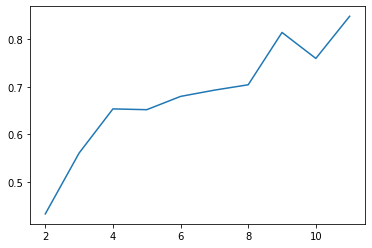

In [8]:
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=100)
processed = process_results(experiment_results)
generate_graph_all(processed)
plot_change_in_ci(processed)

# Check to see if JSON works

In [ ]:
import json

with open('./experiment_results.json', 'r') as fcc_file:
    experiment_results = json.load(fcc_file)
    print(experiment_results)

In [ ]:
experiment_results

In [ ]:
processed = process_results(experiment_results)
generate_graph_all(processed)

 # Mutli_species_testing

In [ ]:
test_data = data[data["IN FILE"] == 'XC23899_-_White-vented_Shama_-_Copsychus_niger.mp3']
test_data

In [ ]:
get_pairwise_iou(test_data, np.unique(test_data["LAST MOD BY"]))

In [ ]:
get_silhoutte_confidence(test_data, np.unique(test_data["LAST MOD BY"]))

In [ ]:
get_silhoutte_users_confidence(test_data, np.unique(test_data["LAST MOD BY"]))

In [ ]:
fast_majority_vote(test_data, np.unique(test_data["LAST MOD BY"]))

# Species Wise

In [ ]:
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000)
processed = process_results(experiment_results)
generate_graph_all(processed)

# Bird Wise

In [ ]:
data[ "MANUAL ID MAIN"] = data["MANUAL ID"]
data["MANUAL ID"] = "bird"

In [ ]:
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000)
processed = process_results(experiment_results)
generate_graph_all(processed)

In [ ]:
just_bird_data = data.copy()
just_bird_data["MANUAL ID"] =

confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000)
processed = process_results(experiment_results)
generate_graph_all(processed)